# Introduction
The following program was authored by Max Tejera in 2023-2024. The program was written to conduct analysis on the impacts of the Colorado Equal Pay for Equal Work Act (EPEWA) on the gender wage gap in Colorado. The original analysis was for Max's master of economics capstone research project at the University of Colorado Denver during the fall term of 2023. The code was originally authored in Stata, but has been translated to Python here with some additional functionality.

# Section 0: Setup
These two blocks install / import libraries that will be used in the project.

In [1]:
pip install ipumspy pandas beautifulsoup4 lxml statsmodels plotly tabulate

In [2]:
import pandas as pd
import numpy as np
import ipumspy as ipums
import gzip
import shutil
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.graph_objects as go
import warnings
import re
from ipumspy import IpumsApiClient, CpsExtract, readers, ddi
from bs4 import BeautifulSoup
from pathlib import Path
from ipumspy import readers
from bs4 import BeautifulSoup
from tabulate import tabulate

# Section 1: Load Current Population Survey Data via API
This section uses the IPUMSPY library from IPUMS and an API key saved to a local disk folder to load the selected sample from the Current Population Survey (CPS) into a Pandas dataframe.

The selected sample is every month of the survey since January 2010. Later on the sample will be divided into the two time periods by the EPEWA variable (Equal Pay for Equal Work Act). EPEWA was passed during the Colorado 2019 legislative session and came into effect January 2021. To create a before and after comparison, the pre-law period was defined as January 2010 to December 2020. This period was chosen because the U.S. economy was mostly stable during this time, with some major abberations in the latter 10 months of 2020. This pre-law period is intended to capture a pre-trend in the gender wage gap prior to EPEWA coming into effect. The larger sample of 2010-2019 period likely offsets any major disruptions from the pandemic.

The CPS variables selected are elaborated on in the later sections. The number of variables selected has been minimized to optimize loading time. Loading the data into the Pandas can take a long time. As of this writing, the loading step takes approximately 30 minutes. I believe this is due to how IPUMSPY maps the data while loading.

The sample names were pulled from __[IPUMS](https://cps.ipums.org/cps-action/samples/sample_ids)__. There is room to improve this code by webscraping the sample names, which the webpage is set up to do so conveniently.

IPUMS requires all researchers to cite them when using their data. They are cited below and within the code.

##### Citation
> Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Megan Schouweiler, and Michael Westberry. IPUMS CPS: Version 11.0 [dataset]. Minneapolis, MN: IPUMS, 2023. https://doi.org/10.18128/D030.V11.0

##### To Do:
> 1. Optimize Loading Code For Faster Processing
> 2. Webscrape Sample Names

In [3]:
# Open IPUMS API

api_key_file_path = r"C:\EconThesis\EqualPayForEqualWork\IPUMSAPIKEY03212024.txt"
with open(api_key_file_path, "r") as file:
    api_key = file.read().strip()

ipums = IpumsApiClient(api_key)

In [4]:
# Define sample of the Current Population Survey to extract from IPUMS.
# The CPS Samples come from here:
# https://cps.ipums.org/cps-action/samples/sample_ids

CpsSamples = [
'cps2010_01s',	'cps2010_02b',	'cps2010_03b',	'cps2010_04b',	'cps2010_05s',	'cps2010_06s',	'cps2010_07s',	'cps2010_08s',	'cps2010_09s',	'cps2010_10s',	'cps2010_11s',	'cps2010_12s',
'cps2011_01s',	'cps2011_02b',	'cps2011_03b',	'cps2011_04b',	'cps2011_05s',	'cps2011_06s',	'cps2011_07s',	'cps2011_08s',	'cps2011_09s',	'cps2011_10s',	'cps2011_11s',	'cps2011_12s',
'cps2012_01s',	'cps2012_02b',	'cps2012_03b',	'cps2012_04b',	'cps2012_05s',	'cps2012_06s',	'cps2012_07s',	'cps2012_08s',	'cps2012_09s',	'cps2012_10s',	'cps2012_11s',	'cps2012_12s',
'cps2013_01b',	'cps2013_02s',	'cps2013_03b',	'cps2013_04b',	'cps2013_05b',	'cps2013_06s',	'cps2013_07s',	'cps2013_08s',	'cps2013_09s',	'cps2013_10s',	'cps2013_11s',	'cps2013_12s',
'cps2014_01s',	'cps2014_02s',	'cps2014_03b',	'cps2014_04b',	'cps2014_05b',	'cps2014_06s',	'cps2014_07s',	'cps2014_08s',	'cps2014_09s',	'cps2014_10s',	'cps2014_11s',	'cps2014_12s',
'cps2015_01s',	'cps2015_02s',	'cps2015_03b',	'cps2015_04b',	'cps2015_05s',	'cps2015_06s',	'cps2015_07s',	'cps2015_08s',	'cps2015_09s',	'cps2015_10s',	'cps2015_11b',	'cps2015_12s',
'cps2016_01s',	'cps2016_02s',	'cps2016_03b',	'cps2016_04b',	'cps2016_05b',	'cps2016_06s',	'cps2016_07b',	'cps2016_08s',	'cps2016_09s',	'cps2016_10s',	'cps2016_11s',	'cps2016_12s',
'cps2017_01b',	'cps2017_02s',	'cps2017_03b',	'cps2017_04b',	'cps2017_05s',	'cps2017_06s',	'cps2017_07s',	'cps2017_08s',	'cps2017_09s',	'cps2017_10s',	'cps2017_11s',	'cps2017_12s',
'cps2018_01s',	'cps2018_02s',	'cps2018_03b',	'cps2018_04b',	'cps2018_05s',	'cps2018_06s',	'cps2018_07s',	'cps2018_08s',	'cps2018_09s',	'cps2018_10s',	'cps2018_11s',	'cps2018_12s',
'cps2019_01s',	'cps2019_02s',	'cps2019_03b',	'cps2019_04b',	'cps2019_05s',	'cps2019_06s',	'cps2019_07s',	'cps2019_08s',	'cps2019_09s',	'cps2019_10s',	'cps2019_11s',	'cps2019_12s',
'cps2020_01s',	'cps2020_02s',	'cps2020_03b',	'cps2020_04b',	'cps2020_05b',	'cps2020_06s',	'cps2020_07b',	'cps2020_08s',	'cps2020_09b',	'cps2020_10s',	'cps2020_11s',	'cps2020_12s',
'cps2021_01b',	'cps2021_02s',	'cps2021_03b',	'cps2021_04b',	'cps2021_05b',	'cps2021_06s',	'cps2021_07s',	'cps2021_08s',	'cps2021_09s',	'cps2021_10s',	'cps2021_11s',	'cps2021_12s',
'cps2022_01s',	'cps2022_02s',	'cps2022_03b',	'cps2022_04s',	'cps2022_05s',	'cps2022_06s',	'cps2022_07s',	'cps2022_08s',	'cps2022_09s',	'cps2022_10s',	'cps2022_11s',	'cps2022_12s',
'cps2023_01s',	'cps2023_02s',	'cps2023_03b',	'cps2023_04b',	'cps2023_05b',	'cps2023_06s',	'cps2023_07s',	'cps2023_08s',	'cps2023_09s',	'cps2023_10s',	'cps2023_11s',	'cps2023_12s',
'cps2024_01s',	'cps2024_02b',	'cps2024_03b',	'cps2024_04b',						
]

CpsVariables = [
    "YEAR", 
    "MONTH", 
    "MISH",
    "STATEFIP", 
    "METFIPS", 
    "EARNWEEK2", 
    "AGE", 
    "SEX", 
    "RACE", 
    "HISPAN", 
    "IND", 
    "CLASSWKR",
    "WKSTAT", 
    "EDUC",
]

extract = CpsExtract(samples=CpsSamples, variables=CpsVariables, collection='cps')

print('Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Megan Schouweiler, and Michael Westberry. IPUMS CPS: Version 11.0 [dataset]. Minneapolis, MN: IPUMS, 2023. https://doi.org/10.18128/D030.V11.0')

Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Megan Schouweiler, and Michael Westberry. IPUMS CPS: Version 11.0 [dataset]. Minneapolis, MN: IPUMS, 2023. https://doi.org/10.18128/D030.V11.0


In [5]:
# Submit the extract request using the client object

extract_id = ipums.submit_extract(extract)
print(extract_id)

In [6]:
# Confirm IPUMS extract has been started or finished

extract_status = ipums.extract_status(extract)
print(extract_status)

started


In [7]:
# Wait for the extract to finish

ipums.wait_for_extract(extract)

In [8]:
# Define where the extract will be downloaded

download_dir = Path(r"C:\EconThesis\EqualPayForEqualWork")
ipums.download_extract(extract_id, download_dir=download_dir)
print(f"Extract downloaded to: {download_dir}")

Extract downloaded to: C:\EconThesis\EqualPayForEqualWork


In [9]:
# Reference the most recently downloaded files

xml_files = sorted(download_dir.glob("*.xml"), key=lambda f: f.stat().st_mtime)
dat_gz_files = sorted(download_dir.glob("*.dat.gz"), key=lambda f: f.stat().st_mtime)
ddi_file = xml_files[-1]
dat_gz_file = dat_gz_files[-1]

# Read the DDI file, which maps the raw data

ddi = readers.read_ipums_ddi(ddi_file)

# Get the correct .dat file name from the DDI

dat_file = download_dir / ddi.file_description.filename

if not dat_file.name.endswith('.dat'):
    dat_file = dat_file.with_suffix('.dat')

if not dat_file.exists():
    with gzip.open(dat_gz_file, 'rb') as f_in:
        with open(dat_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed data file saved to: {dat_file}")

# The next step uses the DDI file and the .dat data file to read the IPUMS data into Pandas for later manipulation.

C:\Users\tejer\anaconda3\lib\site-packages\ipumspy\readers.py:49: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.
  warnings.warn(


Decompressed data file saved to: C:\EconThesis\EqualPayForEqualWork\cps_00046.dat


The dataset is large and must be organized with the DDI file.
The next step breaks the database into small chunks and applies filters to the data to make this task faster.
The step still runs slowly - about 30 minutes. To speed this process up, the dataset is pre-filtered as it is loaded. The original dataset had approximately 8 million observations. The dataset ultimately used for analysis will have approximately half a million observations. Given so many are dropped, below is an explanation for the exclusions:

1. The CPS interviews respondents for four months, takes an eight month break, then interviews them again for four months. The CPS does this in rotation. Therefore, only one eigth of the data in the CPS represents a unique respondent. MISH==8 selects the last month of interviews for a given respondent. This is the last month in which the respondent is asked about their weekly earnings, the primary variable of interest.
2. To allow for a more direct comparison of male and female workers, only full-time workers (35+ hours / week) were considered. These are coded as WKSTAT==11.
3. Similarly, to allow for a more direct comparison of workers only 'Prime Working Age' workers are considered. This is to exclude workers that may have high variation due to school schedules (less than age 25) or may be experiencing wage penalties for approaching retirement (greater than 54).
4. EARNWEEK2 is the endogenous variable of interest. It is what the respondent reported earning from employment before taxes during the week of the 12th in the prior month. Starting in 2023, the CPS began rounding these values to preserve privacy of higher earning respondents. Any respondents making above 150,000 per year were rounded or topcoded to preserve privacy. This removes any variation above this income level and warrants excluding those observations in which EARNWEEK2 is the equivalent of 150,000 per year or more. This likely means all measures of the gender wage gap considered in the analysis are lower than in the population, as men tend to be more represented in higher income and leadership roles.
5. Respondents reporting that they make less than the federal minimum wage equivalent (40 hours x 7.25 per hour = 290) were excluded to ensure respondents' answers are consistent with working full time with the more conventional 40 hour work week. Because respondents describe full time has 35+ hours a week, this potentially excludes workers making up to 8.29 per hour but only working 35 hours per week. These workers are unlikely to be affected significantly by EPEWA, so this is considered an acceptable exclusion.

The combination of (4) and (5) above result in the data considering approximately the middle 60% of the U.S. income distribution, with a slight skew to higher earners.

In [10]:
iter_microdata = readers.read_microdata_chunked(ddi, dat_file, chunksize=3000000)

# Apply all filters within the list comprehension

ipums_df_list = [ chunk[ 
    
    (chunk["MISH"] == 8) & 
    (chunk["WKSTAT"] == 11) & 
    (chunk["AGE"] >= 25) & 
    (chunk["AGE"] <= 54) & 
    (chunk["EARNWEEK2"] < 2884.61) & 
    (chunk["EARNWEEK2"] > 290) ] 

for chunk in iter_microdata ]

# Some explanation for these filters:
# MISH=8 are the relevant samples where a unique EARNWEEK variable exists for each person in the sample.
# WKSTAT <= 11 are full time workers.
# The AGE specifications are for prime working age workers.
# The EARNWEEK2 specifications omits people reporting more than $150,000 per year and less than minimum wage.
# This last exclusion is to address topcoding.
# In most cases, CPS does not release specific earnings information for those making above $150,000 per year.

# Concatenate the filtered chunks into one DataFrame
ipums_df = pd.concat(ipums_df_list, ignore_index=True)

In [11]:
# Check the size of the original data extraction
print(len(ipums_df))

534546


In [12]:
# Set display options for future results. This swaps scientific notation for 4 decimal places.

pd.set_option('display.float_format', '{:.4f}'.format)

# Section 2: Minimum Wage Webscrape and Exclusion

The following section scrapes the __[historical](https://www.dol.gov/agencies/whd/state/minimum-wage/history)__ historical and __[current](https://www.dol.gov/agencies/whd/mw-consolidated)__ state minimum wages by state from two webpages hosted by the US DOL, then uses this information to exclude from the sample workers who reported making less than a state's full time minimum wage weekly earnings in a given state in a given year. This exclusion is intended to address omitted variable bias of minimum wage increases reducing the gender wage gap. Because women earn less than men, it is likely that women are more likely to work minimum wage than men and benefit more from minimum wage increases than men. 

This effect can differ significantly by state. In California, the minimum wage doubled between 2010 and 2024. Meanwhile in approximately 20 other states, the federal minimum wage remained constant during this time.

Where the US DOL posts a range of wages for a state minimum, the code assumes the highest of the range as the minimum wages.
Where there is no state minimum wage posted, the code assumes the federal minimum wage.

Once the minimum wage values are scraped, they multiplied by 40 and added to a new dataframe. This dataframe is then merged with the IPUMS dataframe and the exclusion is place on the data.

**A note on methodology:** This approach only excludes those making less than the minimum wage at 40 hours per week. It is likely that minimum wage increases affect those making slightly above minimum wage by applying wage pressures with those with skill premiums slightly above minimum wage workers but participating in similar work. Sometimes this accounted for by excluding those making more than a certain amount above minimum wage (such as $1 more). In the source data, full-time work is classified as 35 hours per week or more, meaning there could be workers in the existing sample working 114% of minimum wage and working 35 hours per week that would be excluded. This is intended to capture those near the minimum wage, but the original approach of excluding a fixed dollar amount or fixed percentage above the minimum wage may be a superior approach.

In [13]:
url = 'https://www.dol.gov/agencies/whd/state/minimum-wage/history'

# Fetch the HTML content

response = requests.get(url)
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')
tables = soup.find_all('table', class_='minwage')

# List to hold all dataframes

mws = []

# Iterate over each table

for table in tables:
    
    rows = table.find_all('tr')
    data = []
    
    headers = [header.get_text() for header in rows[0].find_all('th')]
    
    for row in rows[1:]:
        cols = row.find_all(['td', 'th'])
        cols = [ele.text.strip() for ele in cols]
        data.append(dict(zip(headers, cols)))
    
    # Create a DataFrame and append to the list
    mw = pd.DataFrame(data)
    mws.append(mw)

# Concatenate all DataFrames into one

concat_mw = pd.concat(mws, ignore_index=True)

# Rename state column

concat_mw.rename(columns={'State or otherjurisdiction': 'State'}, inplace=True)

columns_to_drop = [col for col in concat_mw.columns if col != 'State' and col[:4].isdigit() and int(col[:4]) < 2010]
concat_mw.drop(columns=columns_to_drop, inplace=True)

mw = concat_mw.rename(columns={'State': 'State', 
                               '2010': '2010', 
                               '2011': '2011', 
                               '2012': '2012', 
                               '2013': '2013', 
                               '2014': '2014', 
                               '2015': '2015', 
                               '2016': '2016', 
                               '2017': '2017',
                               '2018': '2018', 
                               '2019': '2019', 
                               '2020': '2020', 
                               '2021': '2021', 
                               '2022': '2022', 
                               '2023': '2023'})

consol_mw = mw.groupby('State').first().reset_index()

federal_minimum_wage_row = consol_mw[consol_mw['State'] == 'Federal (FLSA)'].iloc[0]

# Iterate over each year column to replace "..." with the federal minimum wage

for year in consol_mw.columns[1:]:
    consol_mw[year] = consol_mw.apply(
        lambda row: federal_minimum_wage_row[year] if row[year] == "..." else row[year], 
        axis=1
    )

In [14]:
# Data cleaning function

def clean_wage_value(value):

    value_str = str(value)
    
    # Remove notes in parentheses or brackets
    
    if '(' in value_str or '[' in value_str:
        value_str = value_str.split('(')[0].split('[')[0]
    
    # Handle ranges by selecting the higher value
    
    if '-' in value_str:
        value_str = value_str.split('-')[-1]
    
    # Handle slashes by selecting the second (higher) value
    
    if '/' in value_str:
        value_str = value_str.split('/')[-1]
    
    # Format the value as a float, then as a formatted string
    
    try:
        formatted_value = "{:.2f}".format(float(value_str))
    except ValueError:
        # Return original value if conversion fails
        
        formatted_value = value
    
    return formatted_value

# Apply the cleaning function to all year columns

for col in consol_mw.columns[1:]:
    consol_mw[col] = consol_mw[col].apply(clean_wage_value)
    
# Remove territories from data

states_to_remove = ['Puerto Rico', 'U.S. Virgin Islands', 'Guam']
consol_mw = consol_mw[~consol_mw['State'].isin(states_to_remove)]

# Reset the index

consol_mw.reset_index(drop=True, inplace=True)

In [15]:
# Scrape 2024 wages

url = 'https://www.dol.gov/agencies/whd/mw-consolidated'

# Fetch the HTML content

response = requests.get(url)
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table', summary="consolidated minimum wage rates.")

# Initialize a dictionary to hold the state and minimum wage data

minimum_wages_2024 = {}

# Iterate over the table rows to extract state and wage information

for row in table.find_all('tr')[1:]:
    cells = row.find_all('td')
    for cell in cells:

        text = cell.get_text().strip()
        if text and "$" in text:
            
            # Handle special cases with multiple wages (take the highest value)
            
            wages = [wage.strip() for wage in text.split() if "$" in wage]
            highest_wage = max(wages, key=lambda x: float(x.replace("$", "")))
            
            # Extract state abbreviation and wage, ignoring notes
            
            state = text.split("$")[0].strip()
            wage = highest_wage.replace("$", "")
            minimum_wages_2024[state] = wage

# Crosswalk acronymns to full length state names

state_acronym_to_full = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia', 'PR': 'Puerto Rico', 'GU': 'Guam', 'VI': 'Virgin Islands', 'CNMI': 'Northern Mariana Islands',
    'AS': 'American Samoa'
}

minimum_wages_2024_full_names = {state_acronym_to_full[k]: v for k, v in minimum_wages_2024.items() if k in state_acronym_to_full}

In [16]:
# Add 2024 minimum wages to existing scrape table

consol_mw['2024'] = pd.NA

# Update the DataFrame with the 2024 minimum wage values using full state names

for state, wage in minimum_wages_2024_full_names.items():
    
    # Find the row where the state matches and update its 2024 wage
    
    consol_mw.loc[consol_mw['State'] == state, '2024'] = wage
    
# Replace the 2024 <NA> values for minimum wage with the federal minimum wage

federal_minimum_wage_2023 = consol_mw.loc[consol_mw['State'] == 'Federal (FLSA)', '2023'].values[0]

# Replace <NA> values in the '2024' column with the federal minimum wage value for 2023

consol_mw['2024'].fillna(federal_minimum_wage_2023, inplace=True)

# Define the year columns to process

year_columns = [str(year) for year in range(2010, 2025)]

# Convert all wage values to float, removing any leading dollar signs

for col in year_columns:
    consol_mw[col] = consol_mw[col].replace('[\$,]', '', regex=True).astype(float)

In [17]:
# Assertion check to ensure the minimum wages are never declining for a state
# Define the list of year columns in your DataFrame (excluding the 'State' column)

year_columns = [str(year) for year in range(2010, 2025)]

# Initialize a list to keep track of states with decreasing wage values

states_with_decreases = []

# Iterate over each row in the DataFrame

for index, row in consol_mw.iterrows():
    
    # Check each year's wage against the previous year's wage
    
    for i in range(1, len(year_columns)):
        previous_year = year_columns[i-1]
        current_year = year_columns[i]
   
        if pd.notna(row[current_year]) and pd.notna(row[previous_year]) and (float(row[current_year]) < float(row[previous_year])):
            states_with_decreases.append((row['State'], current_year))
            break

if states_with_decreases:
    print("States with at least one year where the minimum wage decreased from the previous year:")
    for state, year in states_with_decreases:
        print(f"State: {state}, Year: {year}")
else:
    print("All states have minimum wages equal to or greater than the previous year for every year.")


All states have minimum wages equal to or greater than the previous year for every year.


In [18]:
# Define the statefips mapping dictionary
state_fip_mapping = {
    'Federal (FLSA)': '00',
    'Alabama': '01',
    'Alaska': '02',
    'Arizona': '04',
    'Arkansas': '05',
    'California': '06',
    'Colorado': '08',
    'Connecticut': '09',
    'Delaware': '10',
    'District of Columbia': '11',
    'Florida': '12',
    'Georgia': '13',
    'Hawaii': '15',
    'Idaho': '16',
    'Illinois': '17',
    'Indiana': '18',
    'Iowa': '19',
    'Kansas': '20',
    'Kentucky': '21',
    'Louisiana': '22',
    'Maine': '23',
    'Maryland': '24',
    'Massachusetts': '25',
    'Michigan': '26',
    'Minnesota': '27',
    'Mississippi': '28',
    'Missouri': '29',
    'Montana': '30',
    'Nebraska': '31',
    'Nevada': '32',
    'New Hampshire': '33',
    'New Jersey': '34',
    'New Mexico': '35',
    'New York': '36',
    'North Carolina': '37',
    'North Dakota': '38',
    'Ohio': '39',
    'Oklahoma': '40',
    'Oregon': '41',
    'Pennsylvania': '42',
    'Rhode Island': '44',
    'South Carolina': '45',
    'South Dakota': '46',
    'Tennessee': '47',
    'Texas': '48',
    'Utah': '49',
    'Vermont': '50',
    'Virginia': '51',    
    'Washington': '53',
    'West Virginia': '54',
    'Wisconsin': '55',
    'Wyoming': '56'
}

# Use map function to create a new column 'statefip'

consol_mw['STATEFIP'] = consol_mw['State'].map(state_fip_mapping)

# Check for states that didn't match the mapping (Debugging step)

unmapped_states = consol_mw[consol_mw['STATEFIP'].isna()]['State'].unique()
print("Unmapped States:", unmapped_states)

Unmapped States: []


In [19]:
# Create minimum weekly earnings for each minimum wage value by year / state
# Loop through the column names representing years from 2010 to 2024

for year in range(2010, 2025):
    column_name = str(year)  # Convert year to string for column name
    
    # Check if the column name exists in the DataFrame
    
    if column_name in consol_mw.columns:
        
        # Create a new column with values multiplied by 40 and add it to consol_mw
        
        consol_mw[f"{column_name}_weekly_minwage"] = consol_mw[column_name] * 40
        
# Rename to minwages

minwages = consol_mw

In [20]:
for year in range(2010, 2025):
    new_column_name = f"{year}_min_earnweek"
    year_column = year
    if year_column in consol_mw.columns:
        consol_mw[new_column_name] = (consol_mw[year_column] * 40.0).astype(float)

In [21]:
# Confirm size of IPUMS dataframe before excluding those making less than minimum wage in a given year / state

print(len(ipums_df))

534546


In [22]:
# Convert STATEFIP in ipums_df to string to match minwages' STATEFIP format
ipums_df['STATEFIP'] = ipums_df['STATEFIP'].astype(str).str.pad(width=2, fillchar='0')

# Initialize an empty DataFrame to hold filtered rows
filtered_df = pd.DataFrame()

# Iterate over the unique years in ipums_df
for year in ipums_df['YEAR'].unique():
    # Extract the column from minwages corresponding to this year's minimum weekly earnings
    weekly_minwage_col = f"{year}_weekly_minwage"
    
    # Ensure STATEFIP is a string in both DataFrames to match correctly
    temp_df = ipums_df[ipums_df['YEAR'] == year].merge(
        minwages[['STATEFIP', weekly_minwage_col]], 
        on='STATEFIP', 
        how='left'
    )
    
    # Ensure correct column access
    temp_filtered = temp_df[temp_df['EARNWEEK2'] > temp_df[weekly_minwage_col]]
    
    # Append the filtered DataFrame to the cumulative filtered DataFrame
    filtered_df = pd.concat([filtered_df, temp_filtered], ignore_index=True)

# Update ipums_df to be the filtered DataFrame
ipums_df = filtered_df.copy()

In [23]:
print(len(ipums_df))

526025


Approximately 8,500 observations were excluded for respondents making below minimum wage for a given year.

# Section 3: Regression Variables and Controls Preparation

Before proceeding to the regressions, additional variables beyond female need to be generated for other considerations. These variables and their explanations are:

**Comparison Categories**: The primary finding is to evaluate whether EPEWA had an impact on the gender wage gap in Colorado. More specifically, whether the EPEWA requirement to include intended pay ranges in job postings reduced the difference in earnings between men and women. To evaluate this, Colorado is compared to the non pay transparent states. Since EPEWA was passed in 2021, two other states passed similar laws in a time frame that allows for comparisons. California and Washington both had laws come into effect in January 2023. These laws were less stringent than EPEWA, applying only to employers with 15 employees or more where EPEWA applied to all employers. Because EPEWA was in effect for two more years (2021 and 2022) and applies to a wider universe of employers, it is anticipated that the reduction in the gender wage gap for Colorado will be greater than Washington, California, and the remaining 47 non pay transparent states. Because California and Washington passed similar laws with less time and less applicability, they are considered to have a weaker treatment effect and it is anticipated that they will have a reduction in the gender wage gap between Colorado and the 47 non pay transparent states. Therefore for the comparisons, a categorical variable with Colorado, Washington, California, and the remaining 47 states is generated. Note: Hawaii passed a similar pay transparency law that came into effect January 2024. Given this represents such a short time in the sample, Hawaii is included with the non pay transparent states. The City of New York is treated similarly for the law that came into effect in November 2022 - it is hard to isolate the geography of New York City in the data as the CPS groups it with Newark.

**Annual Earnings**: The EARNWEEK2 variable is multiplied by 52 to approximately annual earnings for easier comprehension. It is logarithmically transformed for later regression analysis to compare percentage point changes.

**EPEWA**: Defining the period after EPEWA came into effect. There is additional analysis that could be considered that evaluates lags and leads of pay transparency laws coming into effect. As this analysis stands, a simple interpretation of before / after January 2021 when EPEWA came into effect is considered. This is due to other research showing much of the impact in jobs postings including pay ranges occuring in Colorado in the early months of 2021.

In some of the regression analysis, EPEWA in isolation is used to capture wage inflation effects since January 2021.

**Race Categories**: This is to control by race. When measuring the gender wage gap, there is well established intersectionality of wage penalties possibly due to discrimination. In other words there are three known effects that can explain differences in earnings:

1. Workers tend to be paid less if they are a woman.
2. Workers tend to be paid less if they are a person of color.
3. Workers tend to be paid less if they are a woman of color.

When measuring the gender wage gap (1) adding a control for race ensures the analysis is not measuring (3). This controls for omitted variable bias in Colorado, Washington, or California having different racial make ups than the rest of the United States explaining the difference in gender wage gaps.

For this analysis, hispanic is considered a race. Categorization for __[race](https://cps.ipums.org/cps-action/variables/RACE#codes_section)__ and __[hispanic](https://cps.ipums.org/cps-action/variables/HISPAN#codes_section)__
were sourced from IPUMS.

**Industry**: Another possible explanation for the difference in earnings between men and women is that women tend to enter lower paying industries than men. Whether this behavior is due to discrimination against women in the form of societal conditioning or due to innate preferences of women is out of the scope of this analysis. Therefore this analysis considers both.

In court cases for wage discrimination, where components of EPEWA apply, measurements of damages often rely on within-industry wage comparisons. Therefore this analysis considers industry controls the preferred specification.

The industry categorization comes from __[this IPUMS crosswalk](https://usa.ipums.org/usa/volii/indtoindnaics18.shtml)__ of the CPS 'IND' variable to 2-digit NAICS code industries. The crosswalk has three iterations for the time period considered and the relevant code prioritizes the most recent version. The mapping is created by downloading the CSV file, compiling the three columns for 2008 to 2018 onward, and applying to the dataframe.

**Age**: Age is controlled for as a proxy for experience. While aging does not necessarily result in experience accumulation, it is impossible to accumulate experience without aging. Controlling for age accounts for possible differences in experience amongst the two male and female sub samples.

**Education**: Education is another determinant of income that may result in omitted variable bias. Men and women have differing rates of educational attaintment. Men have historically had higher levels of education, but this trend has reversed in more recent years as women make a majority of college enrollments. Controlling for education ensures the analysis does not measure these differing rates of education. The educational categorizations come from __[here](https://cps.ipums.org/cps-action/variables/EDUC#codes_section)__.

In [24]:
# Generate state-specific dummy variables for states with pay transparency active as of Jan 2023.

ipums_df['co'] = (ipums_df['STATEFIP'] == '08')
ipums_df['ca'] = (ipums_df['STATEFIP'] == '06')
ipums_df['wa'] = (ipums_df['STATEFIP'] == '53')

# Use CO, WA, and CA variables to create a single comparison state variable

conditions = [
    ipums_df['ca'] == 1,
    ipums_df['co'] == 1,
    ipums_df['wa'] == 1
]
choices = [1, 2, 3]  # 1 for California, 2 for Colorado, 3 for Washington
ipums_df['comp_cat4'] = np.select(conditions, choices, default=0)

# Convert to a categorical variable with labels

comp_cat4_labels = {0: 'Rest of US', 1: 'California', 2: 'Colorado', 3: 'Washington'}
ipums_df['comp_cat4'] = ipums_df['comp_cat4'].map(comp_cat4_labels).astype('category')

# Display the distribution of the categorical variable

display(ipums_df['comp_cat4'].value_counts(dropna=False))

Rest of US    465745
California     42096
Colorado        9117
Washington      9067
Name: comp_cat4, dtype: int64

In [25]:
# Generate annual earnings variable. This makes results easier to conceptualize over weekly earnings.

ipums_df['earnyear'] = ipums_df['EARNWEEK2'] * 52

# Generate log annual earnings variable. This will allow for percentage point comparisons for most of the regressions.

ipums_df['log_earnyear'] = np.log(ipums_df['earnyear'])

In [26]:
# Create variable for when Equal Pay for Equal Work Act is in effect

ipums_df['epewa'] = (ipums_df['YEAR'] >= 2021).astype(int)

In [27]:
# Create binary gender variable

ipums_df['female'] = (ipums_df['SEX'] == 2).astype(int)

In [28]:
# Create binary variables for race categories including Hispanic. 
# Hispanic is an ethnicity, not a race, but is useful for grouping by race.

ipums_df['hisp'] = (ipums_df['HISPAN'] >= 100).astype(int)
ipums_df['white'] = ((ipums_df['RACE'] == 100) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['black'] = ((ipums_df['RACE'].isin([200, 801])) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['indian'] = ((ipums_df['RACE'].isin([300, 802])) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['asian'] = ((ipums_df['RACE'].isin([651, 803])) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['other_race'] = ((ipums_df['RACE'].isin([652]) | (ipums_df['RACE'] >= 804)) & (ipums_df['hisp'] == 0)).astype(int)

# Combine the binary flags into a single 'race_cat' variable with Hispanic included

conditions = [
    ipums_df['hisp'] == 1,
    ipums_df['white'] == 1,
    ipums_df['black'] == 1,
    ipums_df['indian'] == 1,
    ipums_df['asian'] == 1,
    ipums_df['other_race'] == 1,
]

# Define the race categories including Hispanic

choices = ['Hispanic', 'White', 'Black', 'Indian', 'Asian', 'Other Race']

# Assign race categories based on conditions

ipums_df['race_cat'] = np.select(conditions, choices, default='Not Specified')

# Print the distribution of the race category variable

race_cat_distribution = ipums_df['race_cat'].value_counts(dropna=False)
display(race_cat_distribution)

White         352560
Hispanic       75857
Black          54327
Asian          32624
Indian          6467
Other Race      4190
Name: race_cat, dtype: int64

Note there are no observations that are not specified.

In [29]:
# To create industry categories, load crosswalk from IPUMS

ipums_cw_link = 'https://usa.ipums.org/usa/resources/volii/ind_indnaics_crosswalk_2000_onward_without_code_descriptions.csv'
ipums_cw = pd.read_csv(ipums_cw_link)

In [30]:
def process_ind_codes(code_series):
    if pd.isna(code_series):
        return []
    # Handle float-formatted strings and possible whitespace in entries
    processed_codes = []
    for code in str(code_series).split(','):
        try:
            # Attempt to directly convert to int
            processed_code = int(code.strip())
        except ValueError:
            # If direct conversion fails, treat as float then convert to int
            processed_code = int(float(code.strip()))
        processed_codes.append(processed_code)
    return processed_codes

In [31]:
data_cleaned = ipums_cw.rename(columns={'Unnamed: 0': 'Category'})

data_cleaned['Category'] = data_cleaned['Category'].fillna(method='ffill')

# Convert the IND CODE columns to numeric, handling NaN values by dropping those rows only if all IND CODEs are NaN
data_cleaned['2008-2012 ACS/PRCS IND CODE'] = data_cleaned['2008-2012 ACS/PRCS IND CODE'].apply(process_ind_codes)
data_cleaned['2013-2017 ACS/PRCS IND CODE'] = data_cleaned['2013-2017 ACS/PRCS IND CODE'].apply(process_ind_codes)
data_cleaned['2018 Onward ACS/PRCS IND CODE'] = data_cleaned['2018 Onward ACS/PRCS IND CODE'].apply(process_ind_codes)

# Initialize dictionaries for each year
ind_to_cat_2008 = {}
ind_to_cat_2013 = {}
ind_to_cat_2018 = {}

# Populate each dictionary
for index, row in data_cleaned.iterrows():
    category = row['Category']
    
    for code in row['2008-2012 ACS/PRCS IND CODE']:
        ind_to_cat_2008.setdefault(category, []).append(code)
        
    for code in row['2013-2017 ACS/PRCS IND CODE']:
        ind_to_cat_2013.setdefault(category, []).append(code)
        
    for code in row['2018 Onward ACS/PRCS IND CODE']:
        ind_to_cat_2018.setdefault(category, []).append(code)

# Sort the IND codes within each category for each dictionary
for d in (ind_to_cat_2008, ind_to_cat_2013, ind_to_cat_2018):
    for category in d:
        d[category].sort()

# Function to rename 'nan' to 'N/A'
def rename_nan_categories(dictionary):
    for category in list(dictionary.keys()):
        if pd.isna(category):
            dictionary['N/A'] = dictionary.pop(category)

# Apply the function to each dictionary
rename_nan_categories(ind_to_cat_2008)
rename_nan_categories(ind_to_cat_2013)
rename_nan_categories(ind_to_cat_2018)

In [32]:
def get_category(year, ind_code):
    # Define dictionary usage based on the year
    dictionaries = {
        2008: (ind_to_cat_2008, ind_to_cat_2013, ind_to_cat_2018),
        2013: (ind_to_cat_2013, ind_to_cat_2018, ind_to_cat_2008),
        2018: (ind_to_cat_2018, ind_to_cat_2013, ind_to_cat_2008)
    }
    
    # Determine which year range the input year falls into
    year_key = max(filter(lambda y: y <= year, dictionaries.keys()))
    primary_dict, secondary_dict, tertiary_dict = dictionaries[year_key]
    
    # Function to check dictionaries
    def check_dict(ind_code, dictionary):
        for cat, codes in dictionary.items():
            if ind_code in codes:
                return cat
        return None

    # Iterate over the dictionaries
    for dictionary in (primary_dict, secondary_dict, tertiary_dict):
        category = check_dict(ind_code, dictionary)
        if category:
            return category
    
    return 'N/A'  # Return 'N/A' if no category is found in any dictionary

# Apply the get_category function across the dataframe to set the 'ind_cat20'
ipums_df['ind_cat20'] = ipums_df.apply(lambda row: get_category(row['YEAR'], row['IND']), axis=1)

# Map to readable labels
ipums_df['ind_cat20_label'] = ipums_df['ind_cat20']

# Check outputs specifically for 'N/A'
print("Count of 'N/A' in ind_cat20_label:", ipums_df['ind_cat20_label'].value_counts().get('N/A', 0))

Count of 'N/A' in ind_cat20_label: 0


In [33]:
def get_category_by_dict(ind_code, dictionary):
    """ Helper function to check categorization using a specific dictionary. """
    for cat, codes in dictionary.items():
        if ind_code in codes:
            return cat
    return 'N/A'  # Return 'N/A' if no category is found

# Create subsets of ipums_df for each time range
df_2008_2012 = ipums_df[ipums_df['YEAR'].between(2008, 2012)]
df_2013_2017 = ipums_df[ipums_df['YEAR'].between(2013, 2017)]
df_2018_onward = ipums_df[ipums_df['YEAR'] >= 2018]

# Apply get_category_by_dict for each subset with the appropriate dictionary
df_2008_2012['ind_cat20_label'] = df_2008_2012['IND'].apply(lambda x: get_category_by_dict(x, ind_to_cat_2008))
df_2013_2017['ind_cat20_label'] = df_2013_2017['IND'].apply(lambda x: get_category_by_dict(x, ind_to_cat_2013))
df_2018_onward['ind_cat20_label'] = df_2018_onward['IND'].apply(lambda x: get_category_by_dict(x, ind_to_cat_2018))

# Print the counts for each category by dictionary
print("2008-2012 Categorization Counts:")
print(df_2008_2012['ind_cat20_label'].value_counts())

print("\n2013-2017 Categorization Counts:")
print(df_2013_2017['ind_cat20_label'].value_counts())

print("\n2018 Onward Categorization Counts:")
print(df_2018_onward['ind_cat20_label'].value_counts())


C:\Users\tejer\AppData\Local\Temp\ipykernel_18600\2495267133.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2008_2012['ind_cat20_label'] = df_2008_2012['IND'].apply(lambda x: get_category_by_dict(x, ind_to_cat_2008))
C:\Users\tejer\AppData\Local\Temp\ipykernel_18600\2495267133.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2013_2017['ind_cat20_label'] = df_2013_2017['IND'].apply(lambda x: get_category_by_dict(x, ind_to_cat_2013))


2008-2012 Categorization Counts:
Health Care and Social Assistance:                                           16727
Manufacturing:                                                               15759
Retail Trade:                                                                11663
Educational Services:                                                        11335
Professional, Scientific, and Technical Services:                             8457
Public Administration:                                                        8388
N/A                                                                           7485
Finance and Insurance:                                                        7402
Transportation and Warehousing:                                               5633
Accommodation and Food Services:                                              5364
Other Services (Except Public Administration):                                4472
Administrative and Support and Waste Management and Re

C:\Users\tejer\AppData\Local\Temp\ipykernel_18600\2495267133.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018_onward['ind_cat20_label'] = df_2018_onward['IND'].apply(lambda x: get_category_by_dict(x, ind_to_cat_2018))


Note there are no observations in the 'N/A' category, meaning every observation was assigned.

In [34]:
# Convert AGE to a categorical variable named 'age'

ipums_df['age'] = ipums_df['AGE'].astype('category')

# Optionally, to name categories based on the integer value of AGE:

ipums_df['age'] = ipums_df['age'].cat.rename_categories(lambda x: f"Age {x}")

# Check the first few rows to confirm the conversion

age_distribution = ipums_df['age'].value_counts(dropna=False)
age_distribution = age_distribution.sort_index()
print(age_distribution)

Age 25    15837
Age 26    16748
Age 27    17518
Age 28    17554
Age 29    18214
Age 30    18441
Age 31    18672
Age 32    18384
Age 33    18167
Age 34    17650
Age 35    17842
Age 36    17611
Age 37    17522
Age 38    17268
Age 39    17296
Age 40    17483
Age 41    17616
Age 42    17182
Age 43    17106
Age 44    16972
Age 45    17159
Age 46    17329
Age 47    17338
Age 48    17541
Age 49    17537
Age 50    17719
Age 51    18105
Age 52    17547
Age 53    17525
Age 54    17142
Name: age, dtype: int64


In [35]:
# EDUC crosswalk

educ_crosswalk = {
    2: "None or preschool",
    10: "Grades 1, 2, 3, or 4",
    20: "Grades 5 or 6",
    30: "Grades 7 or 8",
    40: "Grade 9",
    50: "Grade 10",
    60: "Grade 11",
    71: "12th grade, no diploma",
    73: "High school diploma or equivalent",
    81: "Some college but no degree",
    91: "Associate's degree, occupational/vocational",
    92: "Associate's degree, academic program",
    111: "Bachelor's degree",
    123: "Master's degree",
    124: "Professional school degree",
    125: "Doctorate degree",
}


# Convert EDUC to a categorical variable named 'educ'

ipums_df['educ'] = ipums_df['EDUC'].map(educ_crosswalk).astype('category')

# Check the conversion by displaying the first few entries

education_distribution = ipums_df['educ'].value_counts(dropna=False)
education_distribution = education_distribution.sort_index()
print(education_distribution)

12th grade, no diploma                           4333
Associate's degree, academic program            35538
Associate's degree, occupational/vocational     27144
Bachelor's degree                              139782
Doctorate degree                                10045
Grade 10                                         4527
Grade 11                                         6125
Grade 9                                          4537
Grades 1, 2, 3, or 4                             1622
Grades 5 or 6                                    4366
Grades 7 or 8                                    3765
High school diploma or equivalent              134922
Master's degree                                 58045
None or preschool                                 642
Professional school degree                       7208
Some college but no degree                      83424
Name: educ, dtype: int64


# Section 4: Primary Regression Analysis

The following section runs several regressions and produces a few relevant charts.

The primary model uses a regression of the logarithmically transformed annual earnings as the endogenous (y) variable. It uses gender, the EPEWA time period, age, (sometimes) industry, race, and education as exogenous (x) variables.

It also uses the interaction term, female:epewa. This is the primary finding of the regressions. This is the reduction in the gender wage gap attributable to EPEWA and the other pay transparency laws using this difference in difference experimental design.

The code in this section runs regressions for the scenarios in the following list. It runs all of them with robust standard errors.

1. A national model with all controls ("full model") to test functionality.
2. A full model for the comparison groups.
3. A national model without industry controls.
4. A model for the comparison groups without industry controls.

The code runs this for each of the categories in the comparison group.

In [36]:
# Define the formula for the regression model
formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

# Get unique categories in 'comp_cat4'
comp_cat4_categories = ipums_df['comp_cat4'].unique()
regression_results = {}

# Run the regression for each category in 'comp_cat4'
for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    # Check if there are enough records to run a regression
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        
        # Store the coefficients for female and female:epewa interaction
        female_coef = model.params.get('C(female)[T.1]', None)
        interaction_coef = model.params.get('C(female)[T.1]:C(epewa)[T.1]', None)
        
        # Calculate the wage gap before and after considering epewa
        pre_epewa_wage_gap = 1 + female_coef
        post_epewa_wage_gap = pre_epewa_wage_gap + interaction_coef
        
        # Store results in the dictionary
        regression_results[category] = {
            'female_coef': female_coef,
            'interaction_coef': interaction_coef,
            'pre_epewa_wage_gap': pre_epewa_wage_gap,
            'post_epewa_wage_gap': post_epewa_wage_gap
        }

        print(f"Regression for comp_cat4 category {category}:, No Industry Controls")
        display(model.summary())
        print("\n\n")

# Convert the results dictionary to a pandas DataFrame for easier handling
results_df = pd.DataFrame.from_dict(regression_results, orient='index')

# Display the stored data
print('Regression Results for Key Variables by comp_cat4 Category, No Industry Controls')
display(results_df)

Regression for comp_cat4 category Rest of US:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     4168.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:24   Log-Likelihood:            -2.6533e+05
No. Observations:              465745   AIC:                         5.308e+05
Df Residuals:                  465692   BIC:                         5.314e+05
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.2636      0.008   1265.381      0.000      10.248      10.279
C(female)[T.1]                                            -0.2158      0.001   -152.290      0.000      -0.219      -0.213
C(epewa)[T.1]                                              0.1892      0.002     88.547      0.000       0.185       0.193
C(age)[T.Age 26]                                           0.0332      0.005      7.022      0.000       0.024       0.042
C(age)[T.Age 27]                                           0.0598      0.005     12.749      0.000       0.051       0.069
C(age)[T.Age 28]                                           0.0752      0.005     15.963      0.000       0.066       0.084
C(age)[T.Age 29]                                           0.1000      0.005     21.447      0.000       0.091       0.109
C(age)[T.Age 30]                                           0.1087      0.005     23.263      0.000       0.100       0.118
C(age)[T.Age 31]                                           0.1351      0.005     28.795      0.000       0.126       0.144
C(age)[T.Age 32]                                           0.1511      0.005     32.269      0.000       0.142       0.160
C(age)[T.Age 33]                                           0.1577      0.005     33.263      0.000       0.148       0.167
C(age)[T.Age 34]                                           0.1698      0.005     35.608      0.000       0.160       0.179
C(age)[T.Age 35]                                           0.2165      0.005     45.145      0.000       0.207       0.226
C(age)[T.Age 36]                                           0.2338      0.005     48.597      0.000       0.224       0.243
C(age)[T.Age 37]                                           0.2374      0.005     48.941      0.000       0.228       0.247
C(age)[T.Age 38]                                           0.2468      0.005     50.752      0.000       0.237       0.256
C(age)[T.Age 39]                                           0.2451      0.005     50.580      0.000       0.236       0.255
C(age)[T.Age 40]                                           0.2525      0.005     52.150      0.000       0.243       0.262
C(age)[T.Age 41]                                           0.2566      0.005     52.969      0.000       0.247       0.266
C(age)[T.Age 42]                                           0.2550      0.005     52.352      0.000       0.245       0.265
C(age)[T.Age 43]                                           0.2693      0.005     54.658      0.000       0.260       0.279
C(age)[T.Age 44]                                           0.2647      0.005     53.894      0.000       0.255       0.274
C(age)[T




Regression for comp_cat4 category California:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     491.7
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:25   Log-Likelihood:                -23082.
No. Observations:               42096   AIC:                         4.627e+04
Df Residuals:                   42043   BIC:                         4.673e+04
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.2930      0.019    536.822      0.000      10.255      10.331
C(female)[T.1]                                            -0.1507      0.005    -32.227      0.000      -0.160      -0.142
C(epewa)[T.1]                                              0.1993      0.007     30.150      0.000       0.186       0.212
C(age)[T.Age 26]                                           0.0326      0.016      2.101      0.036       0.002       0.063
C(age)[T.Age 27]                                           0.0476      0.015      3.139      0.002       0.018       0.077
C(age)[T.Age 28]                                           0.0733      0.015      4.820      0.000       0.043       0.103
C(age)[T.Age 29]                                           0.1000      0.015      6.667      0.000       0.071       0.129
C(age)[T.Age 30]                                           0.1063      0.015      7.115      0.000       0.077       0.136
C(age)[T.Age 31]                                           0.1316      0.015      8.903      0.000       0.103       0.161
C(age)[T.Age 32]                                           0.1557      0.015     10.280      0.000       0.126       0.185
C(age)[T.Age 33]                                           0.1430      0.015      9.317      0.000       0.113       0.173
C(age)[T.Age 34]                                           0.1762      0.015     11.385      0.000       0.146       0.207
C(age)[T.Age 35]                                           0.2138      0.015     13.838      0.000       0.184       0.244
C(age)[T.Age 36]                                           0.2466      0.015     16.059      0.000       0.217       0.277
C(age)[T.Age 37]                                           0.2617      0.015     16.912      0.000       0.231       0.292
C(age)[T.Age 38]                                           0.2449      0.016     15.559      0.000       0.214       0.276
C(age)[T.Age 39]                                           0.2780      0.016     17.200      0.000       0.246       0.310
C(age)[T.Age 40]                                           0.2626      0.015     17.026      0.000       0.232       0.293
C(age)[T.Age 41]                                           0.2764      0.016     17.175      0.000       0.245       0.308
C(age)[T.Age 42]                                           0.2674      0.016     16.885      0.000       0.236       0.298
C(age)[T.Age 43]                                           0.2829      0.016     17.533      0.000       0.251       0.315
C(age)[T.Age 44]                                           0.2780      0.016     17.369      0.000       0.247       0.309
C(age)[T




Regression for comp_cat4 category Washington:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     87.91
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:26   Log-Likelihood:                -4745.2
No. Observations:                9067   AIC:                             9596.
Df Residuals:                    9014   BIC:                             9973.
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.4539      0.048    216.494      0.000      10.359      10.549
C(female)[T.1]                                            -0.2217      0.010    -22.249      0.000      -0.241      -0.202
C(epewa)[T.1]                                              0.2074      0.014     15.344      0.000       0.181       0.234
C(age)[T.Age 26]                                           0.0496      0.033      1.519      0.129      -0.014       0.114
C(age)[T.Age 27]                                           0.0839      0.031      2.683      0.007       0.023       0.145
C(age)[T.Age 28]                                           0.1015      0.031      3.279      0.001       0.041       0.162
C(age)[T.Age 29]                                           0.1107      0.032      3.456      0.001       0.048       0.173
C(age)[T.Age 30]                                           0.1266      0.031      4.077      0.000       0.066       0.187
C(age)[T.Age 31]                                           0.1949      0.031      6.249      0.000       0.134       0.256
C(age)[T.Age 32]                                           0.1677      0.031      5.479      0.000       0.108       0.228
C(age)[T.Age 33]                                           0.1833      0.031      5.937      0.000       0.123       0.244
C(age)[T.Age 34]                                           0.2198      0.031      7.147      0.000       0.159       0.280
C(age)[T.Age 35]                                           0.2385      0.031      7.763      0.000       0.178       0.299
C(age)[T.Age 36]                                           0.2391      0.032      7.497      0.000       0.177       0.302
C(age)[T.Age 37]                                           0.2466      0.032      7.781      0.000       0.184       0.309
C(age)[T.Age 38]                                           0.3238      0.032     10.106      0.000       0.261       0.387
C(age)[T.Age 39]                                           0.2930      0.033      8.909      0.000       0.229       0.357
C(age)[T.Age 40]                                           0.3020      0.032      9.367      0.000       0.239       0.365
C(age)[T.Age 41]                                           0.2717      0.032      8.374      0.000       0.208       0.335
C(age)[T.Age 42]                                           0.2767      0.033      8.482      0.000       0.213       0.341
C(age)[T.Age 43]                                           0.2537      0.032      7.939      0.000       0.191       0.316
C(age)[T.Age 44]                                           0.2958      0.033      8.874      0.000       0.230       0.361
C(age)[T




Regression for comp_cat4 category Colorado:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     86.54
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:26   Log-Likelihood:                -5137.0
No. Observations:                9117   AIC:                         1.038e+04
Df Residuals:                    9064   BIC:                         1.076e+04
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.3449      0.063    163.780      0.000      10.221      10.469
C(female)[T.1]                                            -0.2189      0.010    -22.194      0.000      -0.238      -0.200
C(epewa)[T.1]                                              0.2103      0.017     12.347      0.000       0.177       0.244
C(age)[T.Age 26]                                          -0.0424      0.034     -1.261      0.207      -0.108       0.024
C(age)[T.Age 27]                                           0.0042      0.034      0.122      0.903      -0.063       0.071
C(age)[T.Age 28]                                           0.0927      0.034      2.747      0.006       0.027       0.159
C(age)[T.Age 29]                                           0.0766      0.033      2.310      0.021       0.012       0.142
C(age)[T.Age 30]                                           0.0677      0.033      2.040      0.041       0.003       0.133
C(age)[T.Age 31]                                           0.0897      0.033      2.736      0.006       0.025       0.154
C(age)[T.Age 32]                                           0.1263      0.034      3.752      0.000       0.060       0.192
C(age)[T.Age 33]                                           0.1584      0.033      4.845      0.000       0.094       0.222
C(age)[T.Age 34]                                           0.1601      0.034      4.691      0.000       0.093       0.227
C(age)[T.Age 35]                                           0.1789      0.035      5.183      0.000       0.111       0.247
C(age)[T.Age 36]                                           0.2911      0.036      8.054      0.000       0.220       0.362
C(age)[T.Age 37]                                           0.2381      0.035      6.860      0.000       0.170       0.306
C(age)[T.Age 38]                                           0.2487      0.035      7.057      0.000       0.180       0.318
C(age)[T.Age 39]                                           0.2521      0.036      6.912      0.000       0.181       0.324
C(age)[T.Age 40]                                           0.2874      0.034      8.402      0.000       0.220       0.354
C(age)[T.Age 41]                                           0.2348      0.035      6.686      0.000       0.166       0.304
C(age)[T.Age 42]                                           0.2792      0.035      7.983      0.000       0.211       0.348
C(age)[T.Age 43]                                           0.3005      0.036      8.340      0.000       0.230       0.371
C(age)[T.Age 44]                                           0.2590      0.036      7.202      0.000       0.189       0.330
C(age)[T




Regression Results for Key Variables by comp_cat4 Category, No Industry Controls


female_coef  interaction_coef  pre_epewa_wage_gap  \
Rest of US      -0.2158            0.0201              0.7842   
California      -0.1507            0.0320              0.8493   
Washington      -0.2217            0.0522              0.7783   
Colorado        -0.2189            0.0785              0.7811   

            post_epewa_wage_gap  
Rest of US               0.8044  
California               0.8813  
Washington               0.8305  
Colorado                 0.8596

The results for all four states considered are statistically significant at the 5% level.

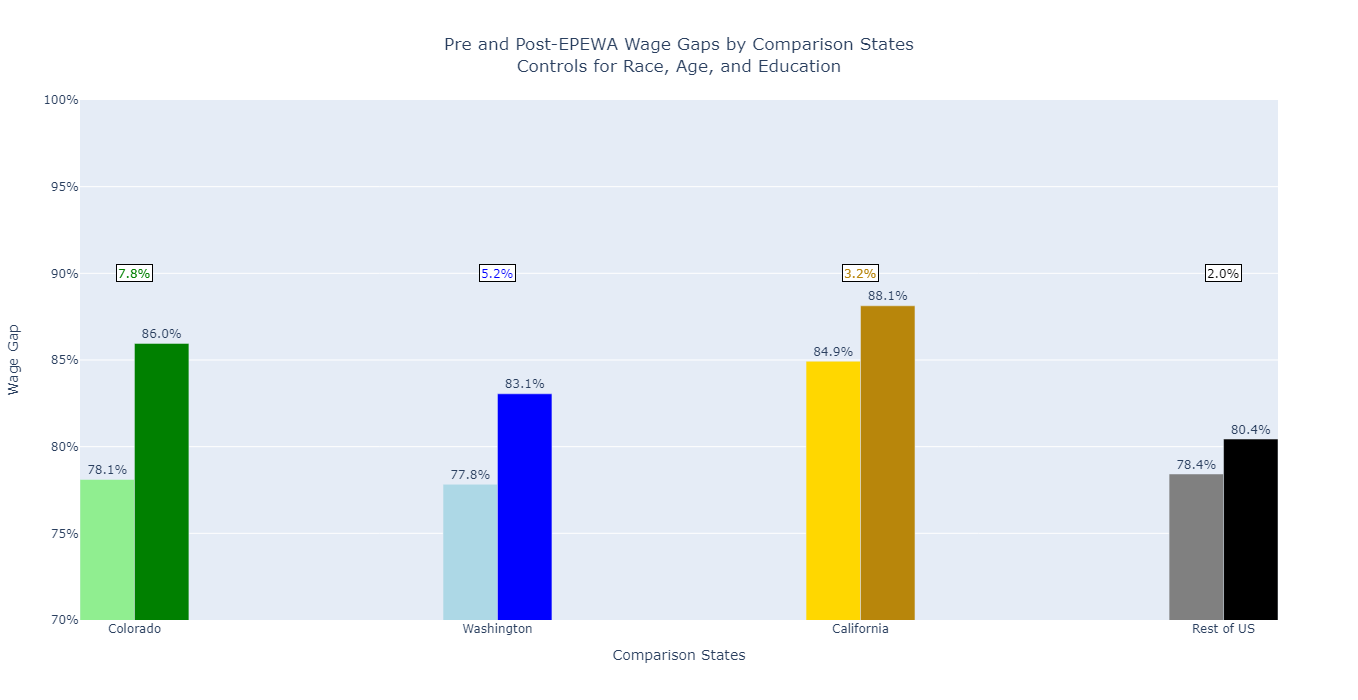

In [37]:
# Sorted categories from results_df
comp_cat4_categories = sorted(results_df.index)

# Sort by reduction
comp_cat4_categories = results_df.sort_values(by='interaction_coef', ascending=False).index

# Initialize color mapping
base_colors = {
    'Colorado': ('lightgreen', 'green'),
    'California': ('gold', 'darkgoldenrod'),
    'Washington': ('lightblue', 'blue'),
    'Rest of US': ('grey', 'black')
}
default_color = ('#D3D3D3', '#A9A9A9')

# Generate colors for each category
state_colors = {cat: default_color for cat in comp_cat4_categories}
for state, colors in base_colors.items():
    for cat in state_colors.keys():
        if state in cat:
            state_colors[cat] = colors

# Create figure with grouped bar chart
fig = go.Figure()

# Bar setup
bar_width = 0.15
bar_offset = bar_width / 2  # Adjust the offset to ensure bars don't overlap

for i, category in enumerate(comp_cat4_categories):
    pre_value = results_df.loc[category, 'pre_epewa_wage_gap']
    post_value = results_df.loc[category, 'post_epewa_wage_gap']
    pre_color, post_color = state_colors[category]
    fig.add_trace(go.Bar(
        x=[i - bar_offset],
        y=[pre_value],
        text=[f"{pre_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Pre-EPEWA Wage Gap',
        marker_color=pre_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    fig.add_trace(go.Bar(
        x=[i + bar_offset],
        y=[post_value],
        text=[f"{post_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Post-EPEWA Wage Gap',
        marker_color=post_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    
# Annotations setup
annotations = []

annotation_y_position = 0.90  # Lower value to lower the annotation position

for i, category in enumerate(comp_cat4_categories):
    # Retrieve the interaction coefficient for the category
    interaction_value = results_df.loc[category, 'interaction_coef']
    # Retrieve the second color from the base_colors
    annotation_color = base_colors.get(category, ('#A9A9A9', '#A9A9A9'))[1]
    # Create an annotation for the interaction coefficient
    annotations.append(
        dict(
            x=i,  # Positioning on the x-axis (aligned with the category)
            y=annotation_y_position,  # Lowered y position for the annotation
            xref='x',
            yref='y',
            text=f"{interaction_value:.1%}",  # Interaction coefficient in .1% format
            showarrow=False,
            font=dict(
                size=12,  # Match the font size with the axis labels
                color=annotation_color  # Set color to match the second color in base_colors
            ),
            bgcolor='white',  # Background color for the annotation box
            bordercolor='black',  # Border color for the annotation box
            borderwidth=1
        )
    )

# Add annotations to the layout
fig.update_layout(annotations=annotations)

# Update layout for better readability and to adjust gaps
fig.update_layout(
    title='Pre and Post-EPEWA Wage Gaps by Comparison States<br>Controls for Race, Age, and Education',
    title_x=0.5,  # Center the title
    xaxis=dict(
        tickangle=0,
        title='Comparison States',
        tickvals=list(range(len(comp_cat4_categories))),
        ticktext=comp_cat4_categories
    ),
    yaxis=dict(
        title='Wage Gap',
        tickformat=".0%",  # Remove decimal places
        range=[0.7, 1]
    ),
    barmode='group',
    showlegend=False,
    bargap=0.05,  # Horizontal gap between different groups
    height=700,  # Make the graph taller
    autosize=True
)

fig.update_layout(width=800)

# Show the plot
fig.show()


The interaction coefficients are significant for all four comparison groups at the 5% level. Their relative values are consistent with the anticipated treatment effects.

In [38]:
# Define the formula for the regression model
formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ) + C(ind_cat20_label)'

# Get unique categories in 'comp_cat4'
comp_cat4_categories = ipums_df['comp_cat4'].unique()
regression_results = {}

# Run the regression for each category in 'comp_cat4'
for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    # Check if there are enough records to run a regression
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        
        # Store the coefficients for female and female:epewa interaction
        female_coef = model.params.get('C(female)[T.1]', None)
        interaction_coef = model.params.get('C(female)[T.1]:C(epewa)[T.1]', None)
        
        # Calculate the wage gap before and after considering epewa
        pre_epewa_wage_gap = 1 + female_coef
        post_epewa_wage_gap = pre_epewa_wage_gap + interaction_coef
        
        # Store results in the dictionary
        regression_results[category] = {
            'female_coef': female_coef,
            'interaction_coef': interaction_coef,
            'pre_epewa_wage_gap': pre_epewa_wage_gap,
            'post_epewa_wage_gap': post_epewa_wage_gap
        }

        print(f"Regression for comp_cat4 category {category}:, Industry Controls")
        display(model.summary())
        print("\n\n")

# Convert the results dictionary to a pandas DataFrame for easier handling
results_df = pd.DataFrame.from_dict(regression_results, orient='index')

# Display the stored data
print('Regression Results for Key Variables by comp_cat4 Category, Industry Controls')
display(results_df)


Regression for comp_cat4 category Rest of US:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     3531.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:42   Log-Likelihood:            -2.5519e+05
No. Observations:              465745   AIC:                         5.105e+05
Df Residuals:                  465673   BIC:                         5.113e+05
Df Model:                          71                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.1044      0.008   1215.656      0.000      10.088      10.121
C(female)[T.1]                                                                                     -0.1824      0.001   -122.310      0.000      -0.185      -0.179
C(epewa)[T.1]                                                                                       0.1878      0.002     90.014      0.000       0.184       0.192
C(age)[T.Age 26]                                                                                    0.0312      0.005      6.791      0.000       0.022       0.040
C(age)[T.Age 27]                                                                                    0.0575      0.005     12.557      0.000       0.049       0.066
C(age)[T.Age 28]                                                                                    0.0699      0.005     15.254      0.000       0.061       0.079
C(age)[T.Age 29]                                                                                    0.0923      0.005     20.350      0.000       0.083       0.101
C(age)[T.Age 30]                                                                                    0.0999      0.005     21.962      0.000       0.091       0.109
C(age)[T.Age 31]                                                                                    0.1252      0.005     27.409      0.000       0.116       0.134
C(age)[T.Age 32]                                                                                    0.1418      0.005     31.074      0.000       0.133       0.151
C(age)[T.Age 33]                                                                                    0.1489      0.005     32.272      0.000       0.140       0.158
C(age)[T.Age 34]                                                                                    0.1603      0.005     34.524      0.000       0.151       0.169
C(age)[T.Age 35]                                                                                    0.2078      0.005     44.418      0.000       0.199       0.217
C(age)[T.Age 36]                                                                                    0.2238      0.005     47.651      0.000       0.215       0.233
C(age)[T.Age 37]                                                                                    0.2278      0.005     48.036      0.000       0.218       0.237
C(age)[T.Age 38]                                                                                    0.2369      0.005     49.864   




Regression for comp_cat4 category California:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     407.5
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:44   Log-Likelihood:                -22208.
No. Observations:               42096   AIC:                         4.456e+04
Df Residuals:                   42024   BIC:                         4.518e+04
Df Model:                          71                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.1660      0.020    500.864      0.000      10.126      10.206
C(female)[T.1]                                                                                     -0.1369      0.005    -28.427      0.000      -0.146      -0.127
C(epewa)[T.1]                                                                                       0.1988      0.006     30.630      0.000       0.186       0.211
C(age)[T.Age 26]                                                                                    0.0294      0.015      1.946      0.052      -0.000       0.059
C(age)[T.Age 27]                                                                                    0.0439      0.015      2.958      0.003       0.015       0.073
C(age)[T.Age 28]                                                                                    0.0686      0.015      4.638      0.000       0.040       0.098
C(age)[T.Age 29]                                                                                    0.0894      0.015      6.126      0.000       0.061       0.118
C(age)[T.Age 30]                                                                                    0.0982      0.015      6.722      0.000       0.070       0.127
C(age)[T.Age 31]                                                                                    0.1222      0.014      8.449      0.000       0.094       0.151
C(age)[T.Age 32]                                                                                    0.1500      0.015     10.081      0.000       0.121       0.179
C(age)[T.Age 33]                                                                                    0.1331      0.015      8.889      0.000       0.104       0.162
C(age)[T.Age 34]                                                                                    0.1615      0.015     10.659      0.000       0.132       0.191
C(age)[T.Age 35]                                                                                    0.2008      0.015     13.296      0.000       0.171       0.230
C(age)[T.Age 36]                                                                                    0.2333      0.015     15.600      0.000       0.204       0.263
C(age)[T.Age 37]                                                                                    0.2494      0.015     16.460      0.000       0.220       0.279
C(age)[T.Age 38]                                                                                    0.2292      0.015     14.871   




Regression for comp_cat4 category Washington:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     77.81
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:44   Log-Likelihood:                -4482.6
No. Observations:                9067   AIC:                             9109.
Df Residuals:                    8995   BIC:                             9621.
Df Model:                          71                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.2520      0.050    206.426      0.000      10.155      10.349
C(female)[T.1]                                                                                     -0.1782      0.010    -17.231      0.000      -0.198      -0.158
C(epewa)[T.1]                                                                                       0.2051      0.013     15.435      0.000       0.179       0.231
C(age)[T.Age 26]                                                                                    0.0460      0.032      1.439      0.150      -0.017       0.109
C(age)[T.Age 27]                                                                                    0.0812      0.031      2.651      0.008       0.021       0.141
C(age)[T.Age 28]                                                                                    0.0978      0.030      3.242      0.001       0.039       0.157
C(age)[T.Age 29]                                                                                    0.0962      0.031      3.097      0.002       0.035       0.157
C(age)[T.Age 30]                                                                                    0.1249      0.030      4.141      0.000       0.066       0.184
C(age)[T.Age 31]                                                                                    0.1911      0.030      6.272      0.000       0.131       0.251
C(age)[T.Age 32]                                                                                    0.1589      0.030      5.323      0.000       0.100       0.217
C(age)[T.Age 33]                                                                                    0.1711      0.030      5.667      0.000       0.112       0.230
C(age)[T.Age 34]                                                                                    0.2144      0.030      7.180      0.000       0.156       0.273
C(age)[T.Age 35]                                                                                    0.2239      0.030      7.515      0.000       0.166       0.282
C(age)[T.Age 36]                                                                                    0.2318      0.031      7.529      0.000       0.171       0.292
C(age)[T.Age 37]                                                                                    0.2351      0.031      7.479      0.000       0.173       0.297
C(age)[T.Age 38]                                                                                    0.3130      0.031     10.009   




Regression for comp_cat4 category Colorado:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     78.35
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:08:45   Log-Likelihood:                -4828.2
No. Observations:                9117   AIC:                             9800.
Df Residuals:                    9045   BIC:                         1.031e+04
Df Model:                          71                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.1782      0.062    164.863      0.000      10.057      10.299
C(female)[T.1]                                                                                     -0.1781      0.010    -17.138      0.000      -0.198      -0.158
C(epewa)[T.1]                                                                                       0.2082      0.016     12.722      0.000       0.176       0.240
C(age)[T.Age 26]                                                                                   -0.0542      0.032     -1.671      0.095      -0.118       0.009
C(age)[T.Age 27]                                                                                   -0.0017      0.033     -0.050      0.960      -0.067       0.064
C(age)[T.Age 28]                                                                                    0.0828      0.033      2.526      0.012       0.019       0.147
C(age)[T.Age 29]                                                                                    0.0633      0.032      1.963      0.050    9.45e-05       0.126
C(age)[T.Age 30]                                                                                    0.0534      0.032      1.649      0.099      -0.010       0.117
C(age)[T.Age 31]                                                                                    0.0701      0.032      2.209      0.027       0.008       0.132
C(age)[T.Age 32]                                                                                    0.1099      0.032      3.408      0.001       0.047       0.173
C(age)[T.Age 33]                                                                                    0.1338      0.032      4.208      0.000       0.071       0.196
C(age)[T.Age 34]                                                                                    0.1327      0.033      3.990      0.000       0.068       0.198
C(age)[T.Age 35]                                                                                    0.1594      0.033      4.800      0.000       0.094       0.224
C(age)[T.Age 36]                                                                                    0.2686      0.035      7.712      0.000       0.200       0.337
C(age)[T.Age 37]                                                                                    0.2164      0.034      6.351      0.000       0.150       0.283
C(age)[T.Age 38]                                                                                    0.2287      0.034      6.634   




Regression Results for Key Variables by comp_cat4 Category, Industry Controls


female_coef  interaction_coef  pre_epewa_wage_gap  \
Rest of US      -0.1824            0.0205              0.8176   
California      -0.1369            0.0332              0.8631   
Washington      -0.1782            0.0577              0.8218   
Colorado        -0.1781            0.0754              0.8219   

            post_epewa_wage_gap  
Rest of US               0.8381  
California               0.8963  
Washington               0.8795  
Colorado                 0.8973

The interaction coefficients are significant for all four comparison groups at the 5% level. Their relative values are consistent with the anticipated treatment effects.

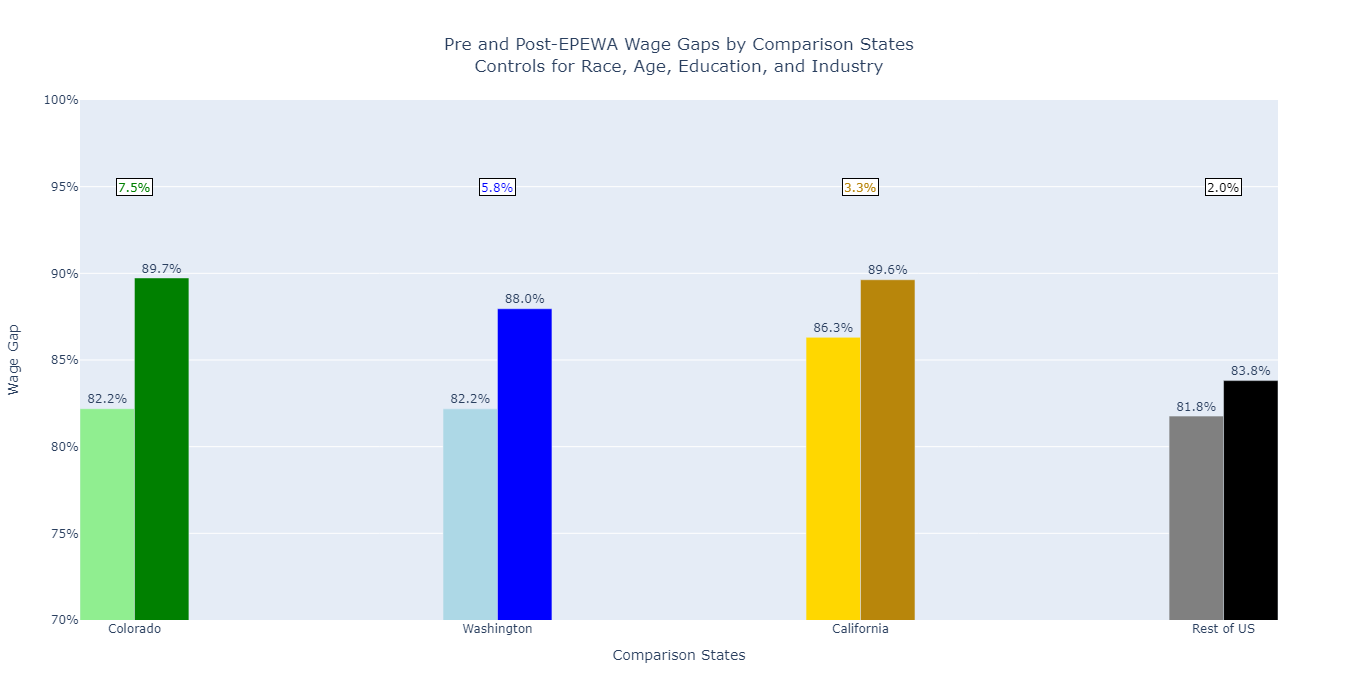

In [39]:
# Sorted categories from results_df
comp_cat4_categories = sorted(results_df.index)

# Sort by reduction
comp_cat4_categories = results_df.sort_values(by='interaction_coef', ascending=False).index

# Initialize color mapping
base_colors = {
    'Colorado': ('lightgreen', 'green'),
    'California': ('gold', 'darkgoldenrod'),
    'Washington': ('lightblue', 'blue'),
    'Rest of US': ('grey', 'black')
}
default_color = ('#D3D3D3', '#A9A9A9')

# Generate colors for each category
state_colors = {cat: default_color for cat in comp_cat4_categories}
for state, colors in base_colors.items():
    for cat in state_colors.keys():
        if state in cat:
            state_colors[cat] = colors

# Create figure with grouped bar chart
fig = go.Figure()

# Bar setup
bar_width = 0.15
bar_offset = bar_width / 2  # Adjust the offset to ensure bars don't overlap

for i, category in enumerate(comp_cat4_categories):
    pre_value = results_df.loc[category, 'pre_epewa_wage_gap']
    post_value = results_df.loc[category, 'post_epewa_wage_gap']
    pre_color, post_color = state_colors[category]
    fig.add_trace(go.Bar(
        x=[i - bar_offset],
        y=[pre_value],
        text=[f"{pre_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Pre-EPEWA Wage Gap',
        marker_color=pre_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    fig.add_trace(go.Bar(
        x=[i + bar_offset],
        y=[post_value],
        text=[f"{post_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Post-EPEWA Wage Gap',
        marker_color=post_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    
# Annotations setup
annotations = []

# You may need to adjust this depending on the specific values and desired appearance
annotation_y_position = 0.95  # Lower value to lower the annotation position

for i, category in enumerate(comp_cat4_categories):
    # Retrieve the interaction coefficient for the category
    interaction_value = results_df.loc[category, 'interaction_coef']
    # Retrieve the second color from the base_colors
    annotation_color = base_colors.get(category, ('#A9A9A9', '#A9A9A9'))[1]
    # Create an annotation for the interaction coefficient
    annotations.append(
        dict(
            x=i,  # Positioning on the x-axis (aligned with the category)
            y=annotation_y_position,  # Lowered y position for the annotation
            xref='x',
            yref='y',
            text=f"{interaction_value:.1%}",  # Interaction coefficient in .1% format
            showarrow=False,
            font=dict(
                size=12,  # Match the font size with the axis labels
                color=annotation_color  # Set color to match the second color in base_colors
            ),
            bgcolor='white',  # Background color for the annotation box
            bordercolor='black',  # Border color for the annotation box
            borderwidth=1
        )
    )

# Add annotations to the layout
fig.update_layout(annotations=annotations)

# Update layout for better readability and to adjust gaps
fig.update_layout(
    title='Pre and Post-EPEWA Wage Gaps by Comparison States<br>Controls for Race, Age, Education, and Industry',
    title_x=0.5,  # Center the title
    xaxis=dict(
        tickangle=0,
        title='Comparison States',
        tickvals=list(range(len(comp_cat4_categories))),
        ticktext=comp_cat4_categories
    ),
    yaxis=dict(
        title='Wage Gap',
        tickformat=".0%",  # Remove decimal places
        range=[0.7, 1]
    ),
    barmode='group',
    showlegend=False,
    bargap=0.05,  # Horizontal gap between different groups
    height=700,  # Make the graph taller
    autosize=True
)

fig.update_layout(width=800)

# Show the plot
fig.show()


The interaction coefficients are significant for all four comparison groups at the 5% level. Their relative values are consistent with the anticipated treatment effects.

# Section 5: State Ranking and Charts

This section of code adds names to the dataset for each individual state (this code could be moved to section 3 but wasn't needed until this point). 

To evaluate how the states rank against each other and the national average for the gender wage gap, the code then runs the regression model for each state and compiles the results into a dataframe. In this dataframe, the code quantifies the measurements of the gender wage gap into the typical 'cents on the dollar' interpretation (women's earnings as a percentage of men's). To evaluate the effects of EPEWA, the code adds the change to the pre-trend value to approximate an after EPEWA value. The code notes any of these approximations where the coefficient of the change was not statistically significant at the 10% level and charts the ranking.

This process is repeated with and without industry controls.

In [40]:
# Give state names to the STATEFIP codes in the ipums_df
# This step could be moved up to the merge between the minwage DF and the IPUMS DF for clarity
# It isn't necessary until this part of the analysis.

state_fip_mapping = {
    '01': 'Alabama',
    '02': 'Alaska',
    '04': 'Arizona',
    '05': 'Arkansas',
    '06': 'California',
    '08': 'Colorado',
    '09': 'Connecticut',
    '10': 'Delaware',
    '11': 'District of Columbia',
    '12': 'Florida',
    '13': 'Georgia',
    '15': 'Hawaii',
    '16': 'Idaho',
    '17': 'Illinois',
    '18': 'Indiana',
    '19': 'Iowa',
    '20': 'Kansas',
    '21': 'Kentucky',
    '22': 'Louisiana',
    '23': 'Maine',
    '24': 'Maryland',
    '25': 'Massachusetts',
    '26': 'Michigan',
    '27': 'Minnesota',
    '28': 'Mississippi',
    '29': 'Missouri',
    '30': 'Montana',
    '31': 'Nebraska',
    '32': 'Nevada',
    '33': 'New Hampshire',
    '34': 'New Jersey',
    '35': 'New Mexico',
    '36': 'New York',
    '37': 'North Carolina',
    '38': 'North Dakota',
    '39': 'Ohio',
    '40': 'Oklahoma',
    '41': 'Oregon',
    '42': 'Pennsylvania',
    '44': 'Rhode Island',
    '45': 'South Carolina',
    '46': 'South Dakota',
    '47': 'Tennessee',
    '48': 'Texas',
    '49': 'Utah',
    '50': 'Vermont',
    '51': 'Virginia',
    '53': 'Washington',
    '54': 'West Virginia',
    '55': 'Wisconsin',
    '56': 'Wyoming'
}

# Ensure the STATEFIP codes are strings and have leading zeros if necessary

ipums_df['STATEFIP'] = ipums_df['STATEFIP'].astype(str).str.pad(2, fillchar='0')

# Map the STATEFIP codes to state names and create the 'state' column

ipums_df['state'] = ipums_df['STATEFIP'].map(state_fip_mapping)

# Convert the 'state' column to a categorical type

ipums_df['state'] = ipums_df['state'].astype('category')

# Verify the mapping

display(ipums_df[['STATEFIP', 'state']].head())

STATEFIP        state
0       01      Alabama
1       01      Alabama
2       01      Alabama
3       09  Connecticut
4       09  Connecticut

In [41]:
# The following code runs the regression for each state
# There are not industry controls in this analysis
# Define the formula for the regression model

formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

state_categories = ipums_df['state'].cat.categories
regression_results = {}

# Run the regression for each state

for state in state_categories:
    subset = ipums_df[ipums_df['state'] == state]
    
    # Check if there are enough records to run a regression
    
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        
        # Store the coefficients and p-values for the variables of interest
        
        regression_results[state] = {
            'female_coef': model.params.get('C(female)[T.1]', None),
            'female_pval': model.pvalues.get('C(female)[T.1]', None),
            'interaction_coef': model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
            'interaction_pval': model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
        }

# Convert the results dictionary to a pandas DataFrame for easier handling

results_df = pd.DataFrame.from_dict(regression_results, orient='index')

# Run the regression for the entire sample

national_model = smf.ols(formula, data=ipums_df).fit(cov_type='HC3')

# Store the national coefficients and p-values

national_results = {
    'female_coef': national_model.params.get('C(female)[T.1]', None),
    'female_pval': national_model.pvalues.get('C(female)[T.1]', None),
    'interaction_coef': national_model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
    'interaction_pval': national_model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
}

# Add the national results to the results_df with the state value 'United States'

results_df.loc['United States'] = national_results

# Display the stored coefficients and p-values

print('Individual State Regression Results for Key Variables, No Industry Controls')
display(results_df)


Individual State Regression Results for Key Variables, No Industry Controls


female_coef  female_pval  interaction_coef  \
Alabama                   -0.2522       0.0000            0.0282   
Alaska                    -0.2306       0.0000            0.0700   
Arizona                   -0.1699       0.0000           -0.0185   
Arkansas                  -0.2151       0.0000            0.0560   
California                -0.1507       0.0000            0.0320   
Colorado                  -0.2189       0.0000            0.0785   
Connecticut               -0.1930       0.0000            0.0264   
Delaware                  -0.1727       0.0000            0.0442   
District of Columbia      -0.0689       0.0000            0.0031   
Florida                   -0.1721       0.0000            0.0340   
Georgia                   -0.2342       0.0000            0.0306   
Hawaii                    -0.1891       0.0000            0.0380   
Idaho                     -0.2418       0.0000            0.0175   
Illinois                  -0.1923       0.0000            0.0100   
Indiana                   -0.2622       0.0000            0.0441   
Iowa                      -0.2435       0.0000            0.0009   
Kansas                    -0.2330       0.0000            0.0091   
Kentucky                  -0.2253       0.0000           -0.0032   
Louisiana                 -0.2644       0.0000           -0.0262   
Maine                     -0.2282       0.0000            0.0271   
Maryland                  -0.1683       0.0000            0.0099   
Massachusetts             -0.1797       0.0000            0.0590   
Michigan                  -0.2224       0.0000            0.0495   
Minnesota                 -0.1904       0.0000            0.0297   
Mississippi               -0.2368       0.0000           -0.0199   
Missouri                  -0.2339       0.0000           -0.0047   
Montana                   -0.2206       0.0000            0.0178   
Nebraska                  -0.2045       0.0000           -0.0153   
Nevada                    -0.1995       0.0000            0.0138   
New Hampshire             -0.2473       0.0000            0.0004   
New Jersey                -0.1852       0.0000            0.0257   
New Mexico                -0.2090       0.0000            0.0285   
New York                  -0.1723       0.0000            0.0242   
North Carolina            -0.1900       0.0000            0.0125   
North Dakota              -0.2709       0.0000            0.0656   
Ohio                      -0.2195       0.0000            0.0143   
Oklahoma                  -0.2526       0.0000           -0.0271   
Oregon                    -0.1831       0.0000            0.0362   
Pennsylvania              -0.2314       0.0000            0.0529   
Rhode Island              -0.2068       0.0000            0.0599   
South Carolina            -0.2293       0.0000            0.0390   
South Dakota              -0.2605       0.0000            0.0738   
Tennessee                 -0.2110       0.0000           -0.0110   
Texas                     -0.2293       0.0000            0.0232   
Utah                      -0.2651       0.0000            0.0412   
Vermont                   -0.1862       0.0000            0.0125   
Virginia                  -0.2203       0.0000            0.0450   
Washington                -0.2217       0.0000            0.0522   
West Virginia             -0.2661       0.0000            0.0207   
Wisconsin                 -0.2197       0.0000            0.0289   
Wyoming                   -0.3465       0.0000            0.0644   
United States             -0.2112       0.0000            0.0221   

                      interaction_pval  
Alabama                         0.1542  
Alaska                          0.0068  
Arizona                         0.4036  
Arkansas                        0.0105  
California                      0.0009  
Colorado                        0.0013  
Connecticut                     0.3451  
Delaware                        0.1089  
District of Columbia            0.8697  
Florida

In [42]:
# Sort the results and rename variables based on the 'cents on the dollar' interpretation

wage_gap_ranking = results_df.copy()
wage_gap_ranking['Pre_EPEWA_Gap'] = wage_gap_ranking['female_coef'] + 1
wage_gap_ranking['Post_EPEWA_Gap'] = wage_gap_ranking['Pre_EPEWA_Gap'] + wage_gap_ranking['interaction_coef']
display(wage_gap_ranking)

female_coef  female_pval  interaction_coef  \
Alabama                   -0.2522       0.0000            0.0282   
Alaska                    -0.2306       0.0000            0.0700   
Arizona                   -0.1699       0.0000           -0.0185   
Arkansas                  -0.2151       0.0000            0.0560   
California                -0.1507       0.0000            0.0320   
Colorado                  -0.2189       0.0000            0.0785   
Connecticut               -0.1930       0.0000            0.0264   
Delaware                  -0.1727       0.0000            0.0442   
District of Columbia      -0.0689       0.0000            0.0031   
Florida                   -0.1721       0.0000            0.0340   
Georgia                   -0.2342       0.0000            0.0306   
Hawaii                    -0.1891       0.0000            0.0380   
Idaho                     -0.2418       0.0000            0.0175   
Illinois                  -0.1923       0.0000            0.0100   
Indiana                   -0.2622       0.0000            0.0441   
Iowa                      -0.2435       0.0000            0.0009   
Kansas                    -0.2330       0.0000            0.0091   
Kentucky                  -0.2253       0.0000           -0.0032   
Louisiana                 -0.2644       0.0000           -0.0262   
Maine                     -0.2282       0.0000            0.0271   
Maryland                  -0.1683       0.0000            0.0099   
Massachusetts             -0.1797       0.0000            0.0590   
Michigan                  -0.2224       0.0000            0.0495   
Minnesota                 -0.1904       0.0000            0.0297   
Mississippi               -0.2368       0.0000           -0.0199   
Missouri                  -0.2339       0.0000           -0.0047   
Montana                   -0.2206       0.0000            0.0178   
Nebraska                  -0.2045       0.0000           -0.0153   
Nevada                    -0.1995       0.0000            0.0138   
New Hampshire             -0.2473       0.0000            0.0004   
New Jersey                -0.1852       0.0000            0.0257   
New Mexico                -0.2090       0.0000            0.0285   
New York                  -0.1723       0.0000            0.0242   
North Carolina            -0.1900       0.0000            0.0125   
North Dakota              -0.2709       0.0000            0.0656   
Ohio                      -0.2195       0.0000            0.0143   
Oklahoma                  -0.2526       0.0000           -0.0271   
Oregon                    -0.1831       0.0000            0.0362   
Pennsylvania              -0.2314       0.0000            0.0529   
Rhode Island              -0.2068       0.0000            0.0599   
South Carolina            -0.2293       0.0000            0.0390   
South Dakota              -0.2605       0.0000            0.0738   
Tennessee                 -0.2110       0.0000           -0.0110   
Texas                     -0.2293       0.0000            0.0232   
Utah                      -0.2651       0.0000            0.0412   
Vermont                   -0.1862       0.0000            0.0125   
Virginia                  -0.2203       0.0000            0.0450   
Washington                -0.2217       0.0000            0.0522   
West Virginia             -0.2661       0.0000            0.0207   
Wisconsin                 -0.2197       0.0000            0.0289   
Wyoming                   -0.3465       0.0000            0.0644   
United States             -0.2112       0.0000            0.0221   

                      interaction_pval  Pre_EPEWA_Gap  Post_EPEWA_Gap  
Alabama                         0.1542         0.7478          0.7760  
Alaska                          0.0068         0.7694          0.8394  
Arizona                         0.4036         0.8301          0.8115  
Arkansas                        0.0105         0.7849          0.8409  
California                      0.0009         0.8493    

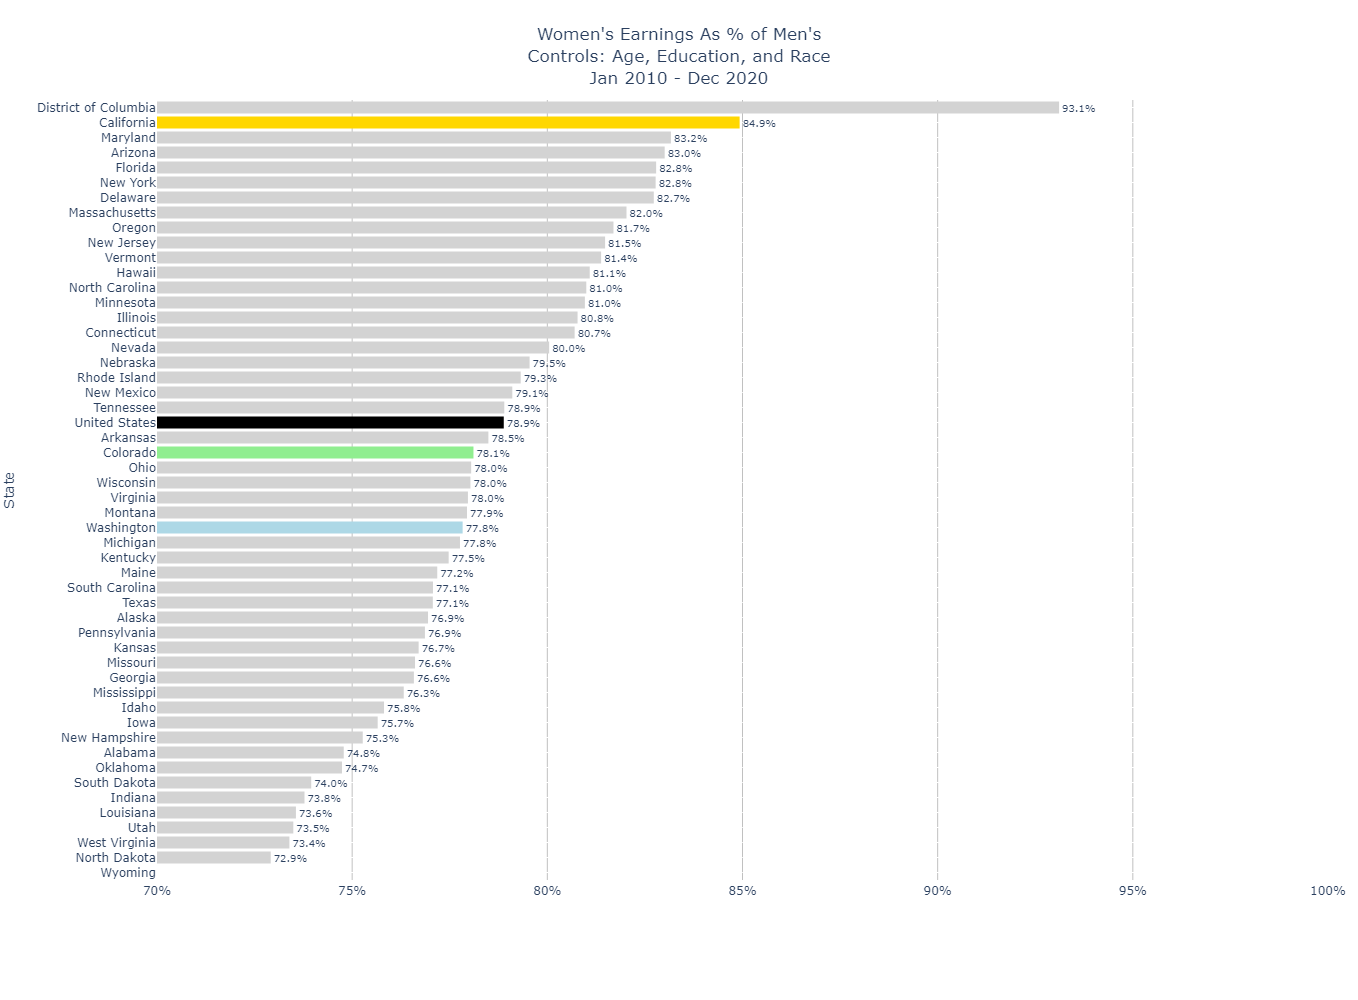

In [43]:
# The following code creates a chart of the results and notes the statistically insignificant results with an asterisks
# Remove existing asterisks from the state names to avoid duplication

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

# Sort wage_gap_ranking by Post_EPEWA_Gap

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

# Define the color for each state

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

# Add asterisks based on the female_pval

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['female_pval'])
]

# Sort wage_gap_ranking by Pre_EPEWA_Gap

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

# Convert Pre_EPEWA_Gap to percentage text for callouts

percentage_labels = wage_gap_ranking['Pre_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

# Create the bar chart

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Pre_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,  # Add percentage labels as text
    textposition='outside'  # Position the text at the end of the bars# Set bar colors based on state
))

# Update the layout to match the desired style

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, and Race<br>Jan 2010 - Dec 2020",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
)

fig.update_traces(marker_line_width=0)

fig.show()

# Remove asterisks again for clean future runs

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

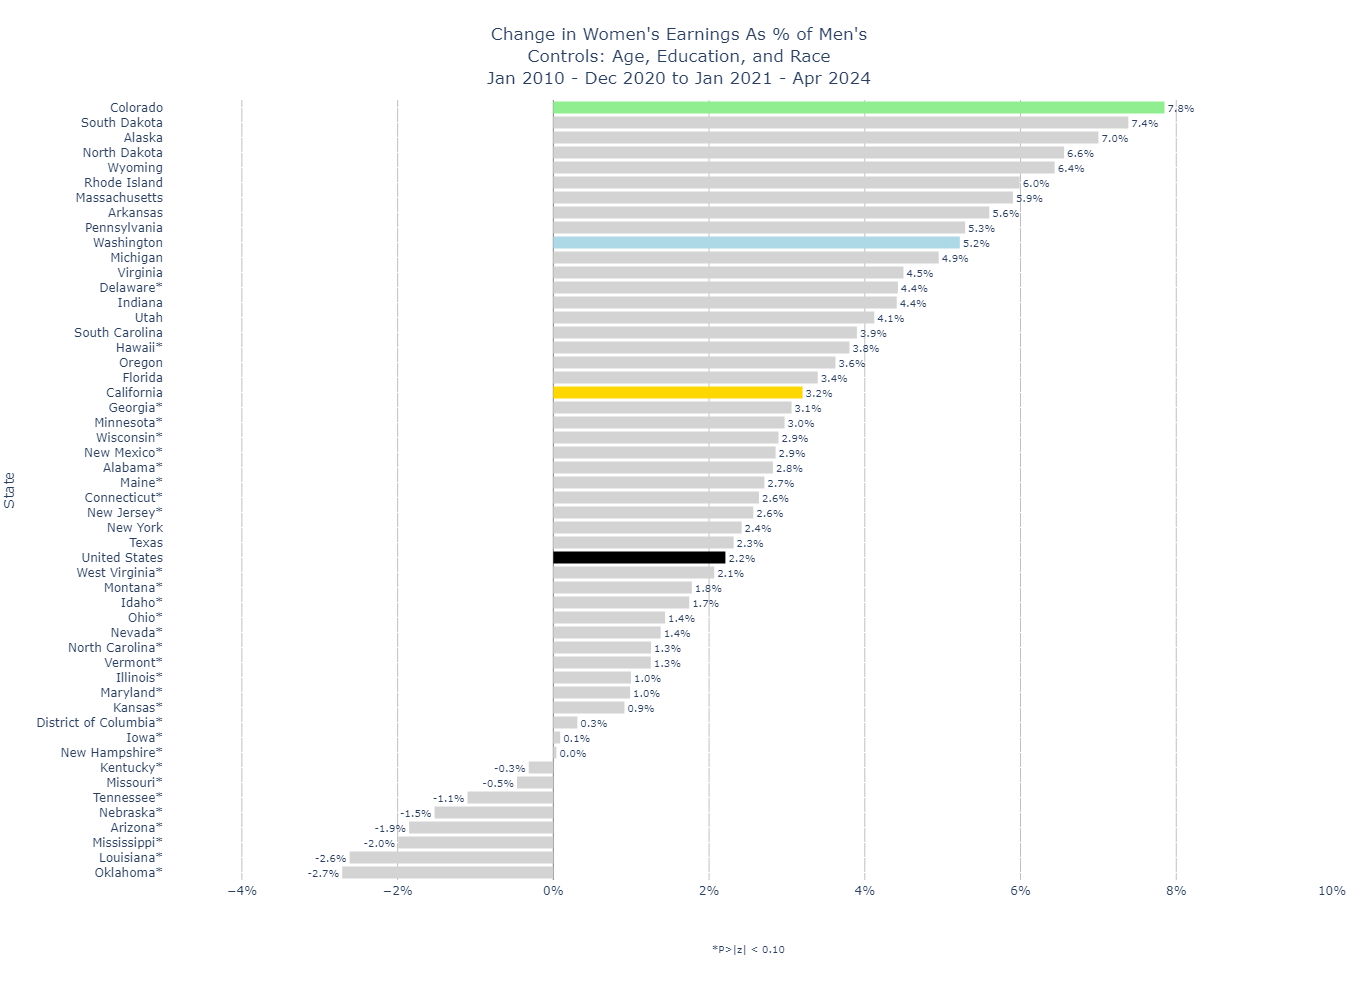

In [44]:
# The following code produces the same chart for the change from before and after the law

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

percentage_labels = wage_gap_ranking['interaction_coef'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['interaction_coef'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Change in Women's Earnings As % of Men's<br>Controls: Age, Education, and Race<br>Jan 2010 - Dec 2020 to Jan 2021 - Apr 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[-0.05, .1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[  # Add note regarding p-value
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

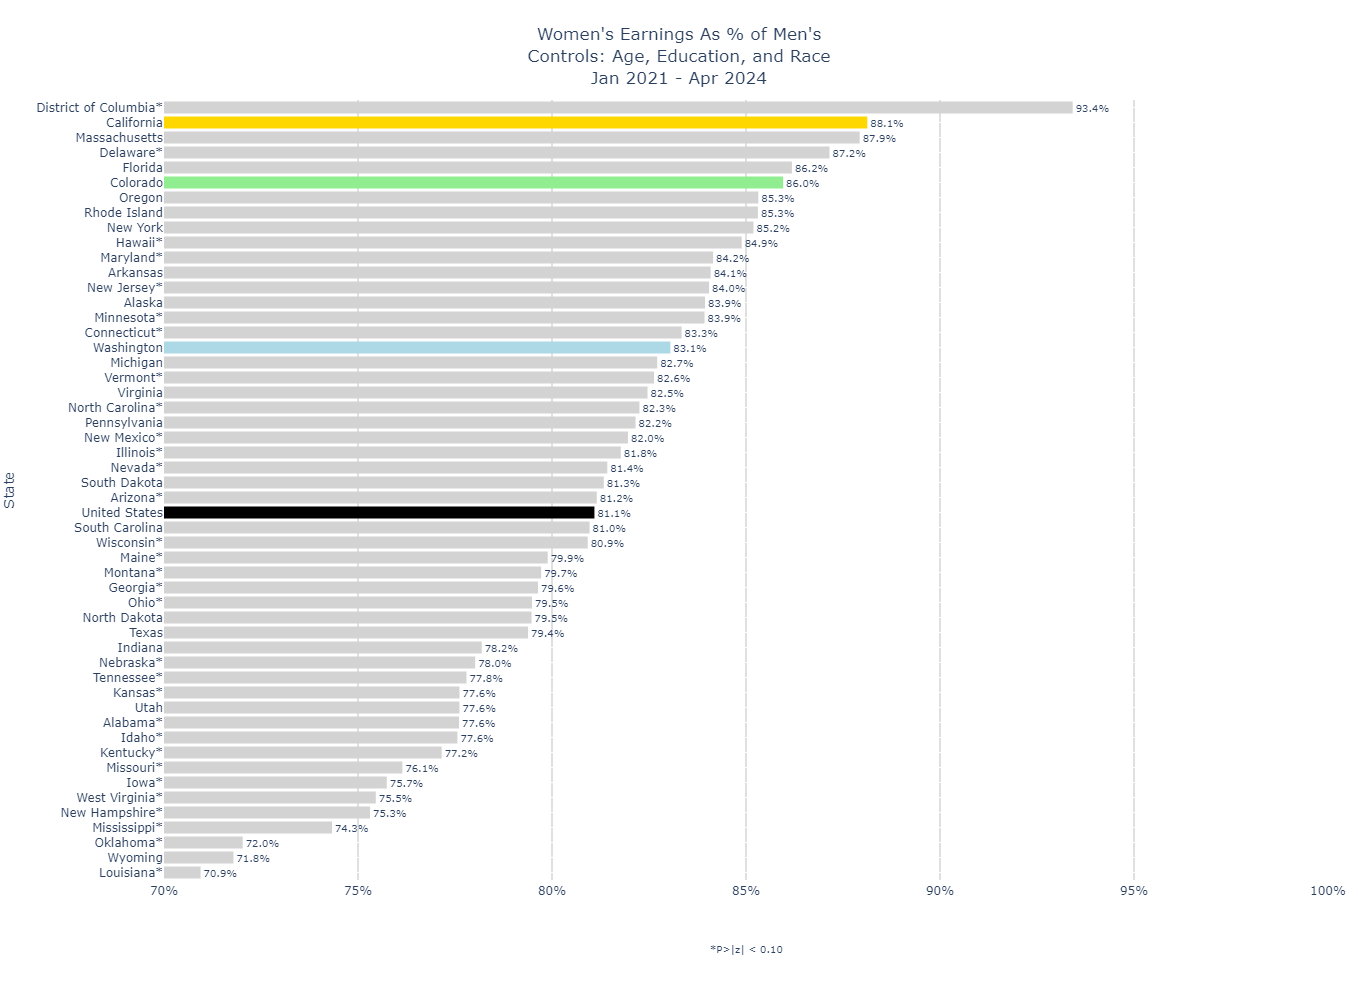

In [45]:
# The following chart shows the sum of the pre-law and change

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'


wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

percentage_labels = wage_gap_ranking['Post_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Post_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, and Race<br>Jan 2021 - Apr 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

In [46]:
# The next several blocks of code recreate the same results, this time with industry controls
# This the preferred specification

formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(ind_cat20_label) + C(race_cat) + C(educ)'

state_categories = ipums_df['state'].cat.categories

regression_results = {}

for state in state_categories:
    subset = ipums_df[ipums_df['state'] == state]
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        regression_results[state] = {
            'female_coef': model.params.get('C(female)[T.1]', None),
            'female_pval': model.pvalues.get('C(female)[T.1]', None),
            'interaction_coef': model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
            'interaction_pval': model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
        }

results_df = pd.DataFrame.from_dict(regression_results, orient='index')

national_model = smf.ols(formula, data=ipums_df).fit(cov_type='HC3')

national_results = {
    'female_coef': national_model.params.get('C(female)[T.1]', None),
    'female_pval': national_model.pvalues.get('C(female)[T.1]', None),
    'interaction_coef': national_model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
    'interaction_pval': national_model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
}

results_df.loc['United States'] = national_results

display(results_df)

female_coef  female_pval  interaction_coef  \
Alabama                   -0.2218       0.0000            0.0280   
Alaska                    -0.1913       0.0000            0.0710   
Arizona                   -0.1483       0.0000           -0.0170   
Arkansas                  -0.1891       0.0000            0.0546   
California                -0.1369       0.0000            0.0332   
Colorado                  -0.1781       0.0000            0.0754   
Connecticut               -0.1759       0.0000            0.0290   
Delaware                  -0.1611       0.0000            0.0526   
District of Columbia      -0.0571       0.0000            0.0053   
Florida                   -0.1672       0.0000            0.0335   
Georgia                   -0.2145       0.0000            0.0324   
Hawaii                    -0.1640       0.0000            0.0441   
Idaho                     -0.2156       0.0000            0.0143   
Illinois                  -0.1521       0.0000            0.0045   
Indiana                   -0.2300       0.0000            0.0483   
Iowa                      -0.2052       0.0000            0.0123   
Kansas                    -0.1839       0.0000           -0.0086   
Kentucky                  -0.1832       0.0000           -0.0096   
Louisiana                 -0.2045       0.0000           -0.0284   
Maine                     -0.1882       0.0000            0.0183   
Maryland                  -0.1386       0.0000            0.0157   
Massachusetts             -0.1477       0.0000            0.0607   
Michigan                  -0.1844       0.0000            0.0485   
Minnesota                 -0.1568       0.0000            0.0292   
Mississippi               -0.2024       0.0000           -0.0131   
Missouri                  -0.1889       0.0000           -0.0031   
Montana                   -0.1762       0.0000            0.0208   
Nebraska                  -0.1693       0.0000           -0.0163   
Nevada                    -0.1726       0.0000            0.0107   
New Hampshire             -0.2122       0.0000            0.0028   
New Jersey                -0.1663       0.0000            0.0264   
New Mexico                -0.1692       0.0000            0.0285   
New York                  -0.1522       0.0000            0.0309   
North Carolina            -0.1750       0.0000            0.0167   
North Dakota              -0.1963       0.0000            0.0516   
Ohio                      -0.1841       0.0000            0.0146   
Oklahoma                  -0.1995       0.0000           -0.0310   
Oregon                    -0.1496       0.0000            0.0453   
Pennsylvania              -0.1994       0.0000            0.0526   
Rhode Island              -0.1758       0.0000            0.0598   
South Carolina            -0.2075       0.0000            0.0405   
South Dakota              -0.2399       0.0000            0.0750   
Tennessee                 -0.1850       0.0000           -0.0103   
Texas                     -0.1869       0.0000            0.0183   
Utah                      -0.2333       0.0000            0.0470   
Vermont                   -0.1568       0.0000            0.0019   
Virginia                  -0.1912       0.0000            0.0410   
Washington                -0.1782       0.0000            0.0577   
West Virginia             -0.2040       0.0000            0.0197   
Wisconsin                 -0.1858       0.0000            0.0352   
Wyoming                   -0.2396       0.0000            0.0412   
United States             -0.1789       0.0000            0.0227   

                      interaction_pval  
Alabama                         0.1540  
Alaska                          0.0051  
Arizona                         0.4352  
Arkansas                        0.0124  
California                      0.0005  
Colorado                        0.0013  
Connecticut                     0.2905  
Delaware                        0.0512  
District of Columbia            0.7723  
Florida

In [47]:
wage_gap_ranking = results_df.copy()

wage_gap_ranking['Pre_EPEWA_Gap'] = wage_gap_ranking['female_coef'] + 1

wage_gap_ranking['Post_EPEWA_Gap'] = wage_gap_ranking['Pre_EPEWA_Gap'] + wage_gap_ranking['interaction_coef']

print('Individual State Regression Results for Key Variables, Industry Controls')
display(wage_gap_ranking)

Individual State Regression Results for Key Variables, Industry Controls


female_coef  female_pval  interaction_coef  \
Alabama                   -0.2218       0.0000            0.0280   
Alaska                    -0.1913       0.0000            0.0710   
Arizona                   -0.1483       0.0000           -0.0170   
Arkansas                  -0.1891       0.0000            0.0546   
California                -0.1369       0.0000            0.0332   
Colorado                  -0.1781       0.0000            0.0754   
Connecticut               -0.1759       0.0000            0.0290   
Delaware                  -0.1611       0.0000            0.0526   
District of Columbia      -0.0571       0.0000            0.0053   
Florida                   -0.1672       0.0000            0.0335   
Georgia                   -0.2145       0.0000            0.0324   
Hawaii                    -0.1640       0.0000            0.0441   
Idaho                     -0.2156       0.0000            0.0143   
Illinois                  -0.1521       0.0000            0.0045   
Indiana                   -0.2300       0.0000            0.0483   
Iowa                      -0.2052       0.0000            0.0123   
Kansas                    -0.1839       0.0000           -0.0086   
Kentucky                  -0.1832       0.0000           -0.0096   
Louisiana                 -0.2045       0.0000           -0.0284   
Maine                     -0.1882       0.0000            0.0183   
Maryland                  -0.1386       0.0000            0.0157   
Massachusetts             -0.1477       0.0000            0.0607   
Michigan                  -0.1844       0.0000            0.0485   
Minnesota                 -0.1568       0.0000            0.0292   
Mississippi               -0.2024       0.0000           -0.0131   
Missouri                  -0.1889       0.0000           -0.0031   
Montana                   -0.1762       0.0000            0.0208   
Nebraska                  -0.1693       0.0000           -0.0163   
Nevada                    -0.1726       0.0000            0.0107   
New Hampshire             -0.2122       0.0000            0.0028   
New Jersey                -0.1663       0.0000            0.0264   
New Mexico                -0.1692       0.0000            0.0285   
New York                  -0.1522       0.0000            0.0309   
North Carolina            -0.1750       0.0000            0.0167   
North Dakota              -0.1963       0.0000            0.0516   
Ohio                      -0.1841       0.0000            0.0146   
Oklahoma                  -0.1995       0.0000           -0.0310   
Oregon                    -0.1496       0.0000            0.0453   
Pennsylvania              -0.1994       0.0000            0.0526   
Rhode Island              -0.1758       0.0000            0.0598   
South Carolina            -0.2075       0.0000            0.0405   
South Dakota              -0.2399       0.0000            0.0750   
Tennessee                 -0.1850       0.0000           -0.0103   
Texas                     -0.1869       0.0000            0.0183   
Utah                      -0.2333       0.0000            0.0470   
Vermont                   -0.1568       0.0000            0.0019   
Virginia                  -0.1912       0.0000            0.0410   
Washington                -0.1782       0.0000            0.0577   
West Virginia             -0.2040       0.0000            0.0197   
Wisconsin                 -0.1858       0.0000            0.0352   
Wyoming                   -0.2396       0.0000            0.0412   
United States             -0.1789       0.0000            0.0227   

                      interaction_pval  Pre_EPEWA_Gap  Post_EPEWA_Gap  
Alabama                         0.1540         0.7782          0.8063  
Alaska                          0.0051         0.8087          0.8797  
Arizona                         0.4352         0.8517          0.8347  
Arkansas                        0.0124         0.8109          0.8655  
California                      0.0005         0.8631    

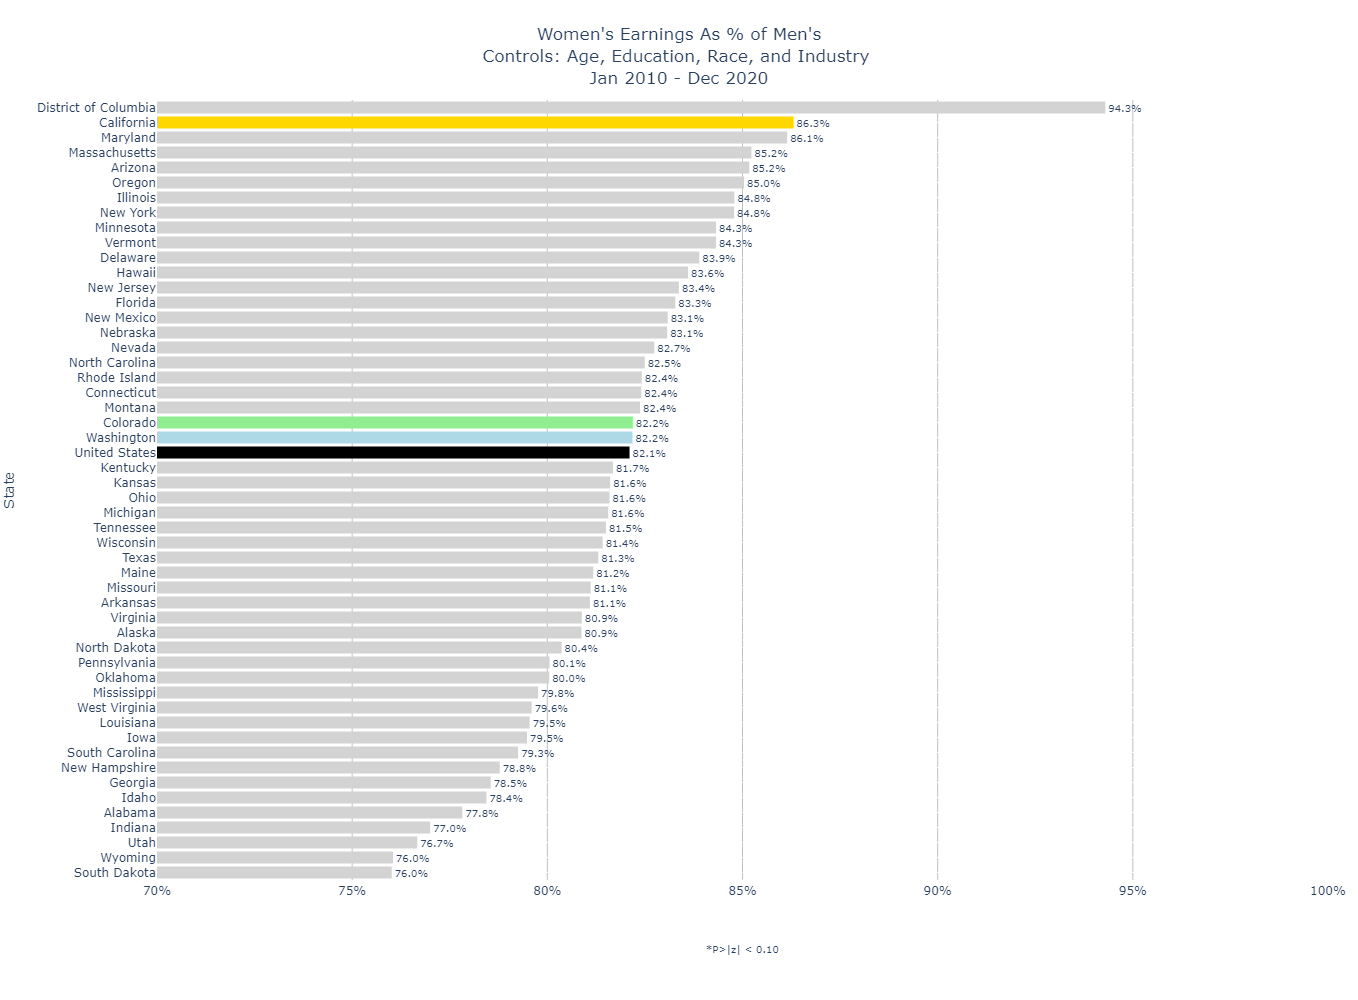

In [48]:
# Pre-EPEWA gap, industry controls

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['female_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

percentage_labels = wage_gap_ranking['Pre_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Pre_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, Race, and Industry <br>Jan 2010 - Dec 2020",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

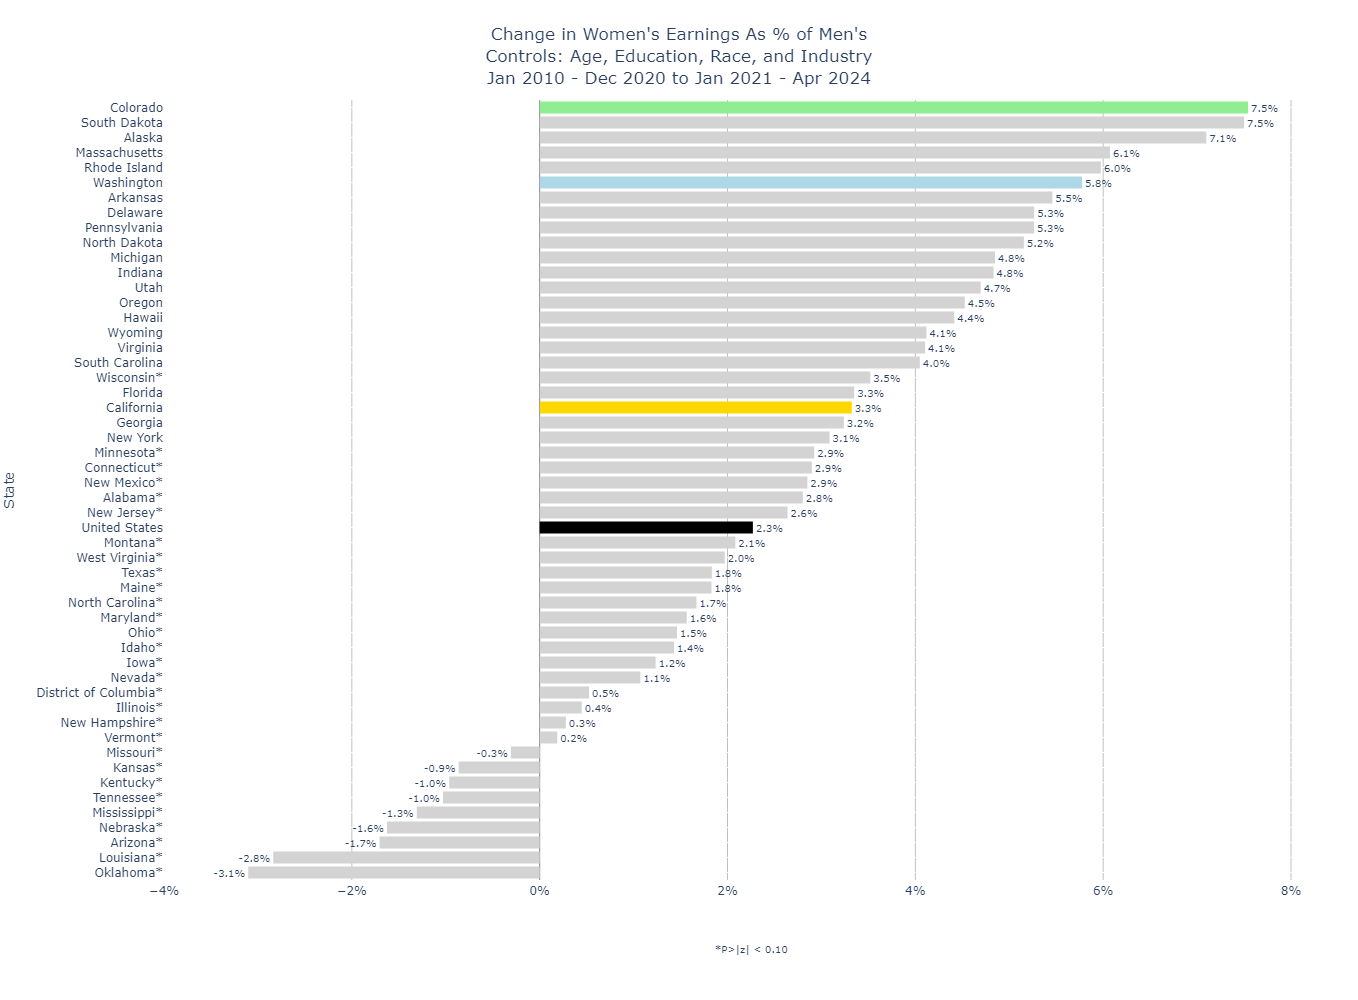

In [49]:
# Change Pre vs. Post EPEWA Gap, Industry Controls

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

percentage_labels = wage_gap_ranking['interaction_coef'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['interaction_coef'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Change in Women's Earnings As % of Men's<br>Controls: Age, Education, Race, and Industry<br>Jan 2010 - Dec 2020 to Jan 2021 - Apr 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[-0.04, .085],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

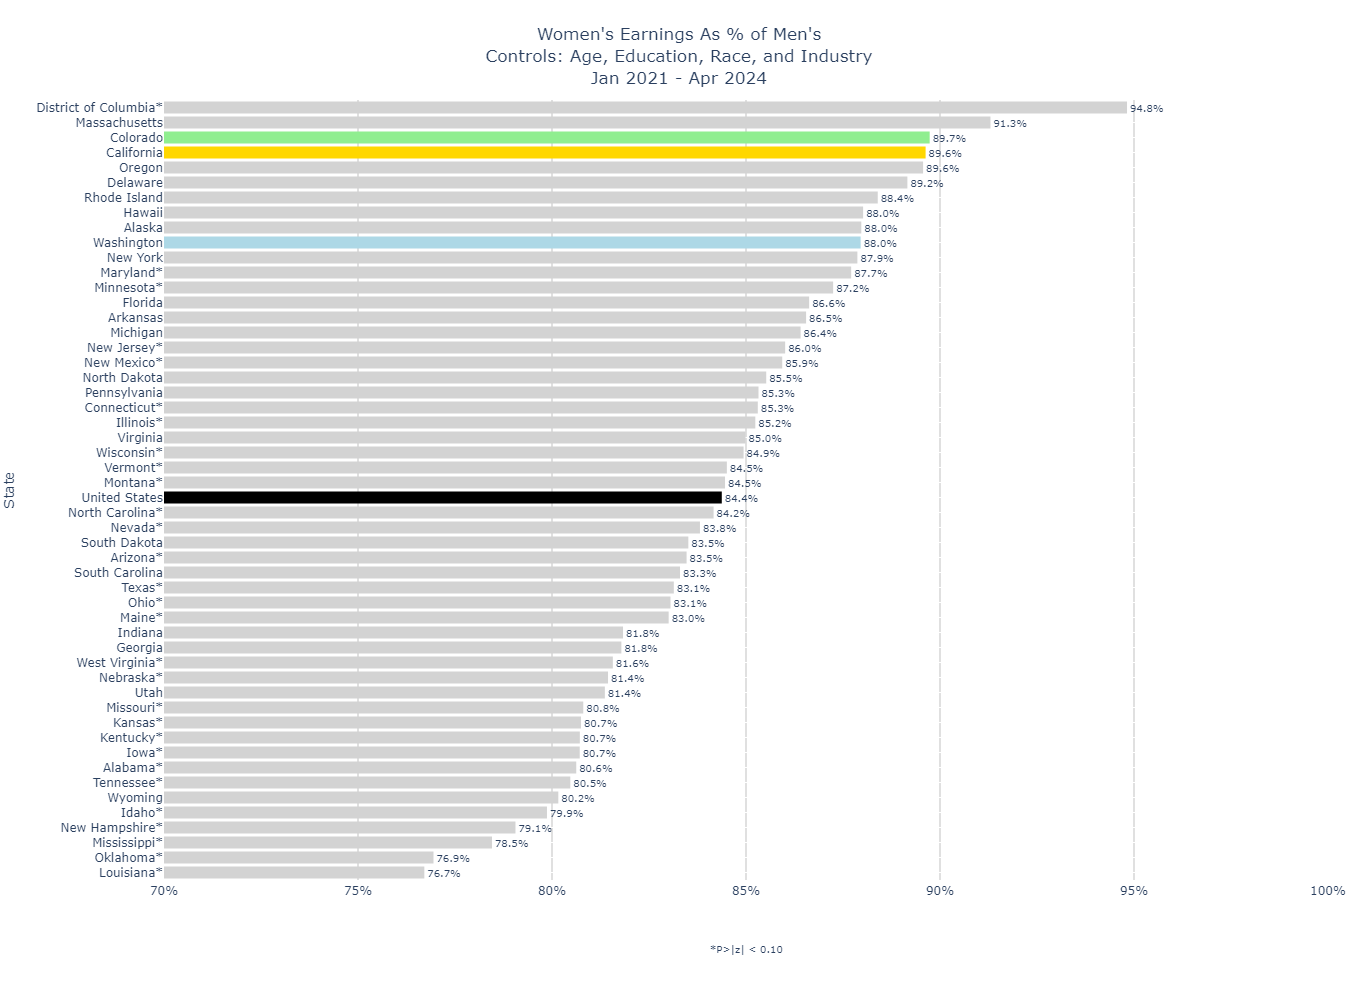

In [50]:
# Post-EPEWA Gap, Industry Controls

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

percentage_labels = wage_gap_ranking['Post_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Post_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, Race, and Industry<br>Jan 2021 - Apr 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

# Section 6: Supplementary Analysis and Robustness Checks

This section of code seeks to analyze some supplementary considerations. These include:

1. Is the reduction in the gender wage gap in Colorado being driven by women's wages going up, or men's wages going down? This is accomplished by repeating the primary regression but with men only in the sample. This compares Colorado men's wages to the rest of the men in the United States.
2. Is the reduction within Colorado determined by a specific industry? This was evaluated by splitting the Colorado subsample into industry-specific samples and running the regression without industry controls. The analysis runs into significant issues due to small sample size
3. Is the reduction in the gender wage gap in Colorado driven by urban or rural parts of the state? Again, this runs into significant issues due to small sample size.
4. What is the increase in women's wages relative to men's in terms of dollars (not percentage points)?

In [51]:
# Define the formula for the regression model without the 'female' variable

formula = 'log_earnyear ~ C(epewa) + C(co) + C(epewa):C(co) + C(age) + C(ind_cat20_label) + C(race_cat) + C(educ)'

# Filter the DataFrame for males only

male_subset = ipums_df[ipums_df['female'] == 0]

# Run formula above

model = smf.ols(formula, data=male_subset).fit(cov_type='HC3')
        
print('Regression Measuring Change in Colorado Male Wages Relative to US, Before and After EPEWA')
display(model.summary())

Regression Measuring Change in Colorado Male Wages Relative to US, Before and After EPEWA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     1976.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:02   Log-Likelihood:            -1.6344e+05
No. Observations:              288980   AIC:                         3.270e+05
Df Residuals:                  288908   BIC:                         3.278e+05
Df Model:                          71                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.0902      0.010   1027.499      0.000      10.071      10.109
C(epewa)[T.1]                                                                                       0.1905      0.002     96.876      0.000       0.187       0.194
C(co)[T.True]                                                                                       0.0387      0.006      6.026      0.000       0.026       0.051
C(age)[T.Age 26]                                                                                    0.0382      0.006      6.290      0.000       0.026       0.050
C(age)[T.Age 27]                                                                                    0.0597      0.006      9.894      0.000       0.048       0.072
C(age)[T.Age 28]                                                                                    0.0790      0.006     13.202      0.000       0.067       0.091
C(age)[T.Age 29]                                                                                    0.1031      0.006     17.299      0.000       0.091       0.115
C(age)[T.Age 30]                                                                                    0.1067      0.006     18.049      0.000       0.095       0.118
C(age)[T.Age 31]                                                                                    0.1397      0.006     23.513      0.000       0.128       0.151
C(age)[T.Age 32]                                                                                    0.1511      0.006     25.564      0.000       0.140       0.163
C(age)[T.Age 33]                                                                                    0.1634      0.006     27.180      0.000       0.152       0.175
C(age)[T.Age 34]                                                                                    0.1807      0.006     29.700      0.000       0.169       0.193
C(age)[T.Age 35]                                                                                    0.2276      0.006     37.358      0.000       0.216       0.240
C(age)[T.Age 36]                                                                                    0.2481      0.006     40.688      0.000       0.236       0.260
C(age)[T.Age 37]                                                                                    0.2572      0.006     41.795      0.000       0.245       0.269
C(age)[T.Age 38]                                                                                    0.2666      0.006     43.290   

There appears to be no statistically significant drop in Colorado men's wages relative to the rest of the United States. While it is statistically insignicant, it appears Colorado men's wages may be increasing relative to the rest of the United States.

In [52]:
# The following code analyzes the effect in Colorado by industry

# Get unique industry categories

industry_categories = ipums_df['ind_cat20'].unique()

# Initialize a dictionary to hold the DataFrames for each industry category

industry_subsets = {}

# Loop through each industry category to create a subset DataFrame when co=1

for industry in industry_categories:
    
    # Subset for each industry where co is 1

    subset = ipums_df[(ipums_df['co'] == 1) & (ipums_df['ind_cat20'] == industry)]
    
    # Add the subset DataFrame to the dictionary with the industry category as the key
    
    industry_subsets[industry] = subset

In [53]:
# Define formula for Colorado within-industry gender wage gap change

formula = 'log_earnyear ~ C(epewa) + C(female) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

regression_results = []

# Loop through each industry category to create a subset DataFrame when co=1 and run regression

for industry in industry_categories:

    # Find the corresponding label for the current industry category
    
    industry_label = ipums_df[ipums_df['ind_cat20'] == industry]['ind_cat20_label'].iloc[0]
    
    # Subset for each industry where co is 1
    
    subset = ipums_df[(ipums_df['co'] == 1) & (ipums_df['ind_cat20'] == industry)]
    
    # Check if the subset is not empty
    
    if not subset.empty:
        
        # Attempt to run the regression on the subset
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", RuntimeWarning)  # Convert RuntimeWarnings to errors
                model = smf.ols(formula, data=subset).fit(cov_type='HC3')
                
                female_coef = model.params.get('C(female)[T.1]')
                female_pval = model.pvalues.get('C(female)[T.1]')
                interaction_coef = model.params.get('C(female)[T.1]:C(epewa)[T.1]')
                interaction_pval = model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]')
                
                regression_results.append({
                    'Industry Label': industry_label,
                    'Female Coefficient': female_coef,
                    'Female P-Value': female_pval,
                    'Interaction Coefficient': interaction_coef,
                    'Interaction P-Value': interaction_pval
                })
        
        except RuntimeWarning:
            print(f"Divide by zero error encountered for {industry_label}. Storing 'Insufficient sample'.")
            
            # Store a placeholder indicating insufficient sample for this industry.
            # This occurs through a combination of sample size and over specification.
            
            regression_results.append({
                'Industry Label': industry_label,
                'Female Coefficient': 'Insufficient sample',
                'Female P-Value': 'Insufficient sample',
                'Interaction Coefficient': 'Insufficient sample',
                'Interaction P-Value': 'Insufficient sample'
            })
        except Exception as e:
            print(f"Skipped regression for {industry_label} due to an error: {e}")

Divide by zero error encountered for Wholesale Trade:. Storing 'Insufficient sample'.
Divide by zero error encountered for Utilities:. Storing 'Insufficient sample'.
Divide by zero error encountered for Real Estate and Rental and Leasing:. Storing 'Insufficient sample'.
Divide by zero error encountered for Arts, Entertainment, and Recreation:. Storing 'Insufficient sample'.
Divide by zero error encountered for Management of Companies and Enterprises:. Storing 'Insufficient sample'.


In [54]:
# Create a DataFrame from the compiled regression results

co_industry_results = pd.DataFrame(regression_results)

display(co_industry_results)

Industry Label   Female Coefficient  \
0   Professional, Scientific, and Technical Services:              -0.3017   
1                              Public Administration:              -0.1362   
2                              Finance and Insurance:              -0.1665   
3                    Accommodation and Food Services:              -0.0694   
4                                    Wholesale Trade:  Insufficient sample   
5                                       Construction:              -0.2165   
6                               Educational Services:              -0.1203   
7      Other Services (Except Public Administration):              -0.2580   
8                                        Information:              -0.1287   
9   Administrative and Support and Waste Managemen...              -0.0999   
10                    Transportation and Warehousing:              -0.3280   
11                                      Retail Trade:              -0.1867   
12                 Health Care and Social Assistance:              -0.1250   
13                                     Manufacturing:              -0.2158   
14                                         Utilities:  Insufficient sample   
15                Real Estate and Rental and Leasing:  Insufficient sample   
16        Agriculture, Forestry, Fishing and Hunting:              -0.4990   
17     Mining, Quarrying, and Oil and Gas Extraction:              -0.3047   
18               Arts, Entertainment, and Recreation:  Insufficient sample   
19           Management of Companies and Enterprises:  Insufficient sample   

         Female P-Value Interaction Coefficient  Interaction P-Value  
0                0.0000                  0.2861               0.0001  
1                0.0005                 -0.1129               0.2368  
2                0.0004                  0.0801               0.4549  
3                0.1565                  0.1038               0.5189  
4   Insufficient sample     Insufficient sample  Insufficient sample  
5                0.0003                  0.0210               0.8521  
6                0.0005                  0.0598               0.4939  
7                0.0000                  0.1294               0.4518  
8                0.0323                  0.0695               0.6534  
9                0.1128                  0.0072               0.9646  
10               0.0000                  0.0874               0.5684  
11               0.0000                  0.1236               0.1084  
12               0.0001                  0.0007               0.9935  
13               0.0000                  0.1179               0.2886  
14  Insufficient sample     Insufficient sample  Insufficient sample  
15  Insufficient sample     Insufficient sample  Insufficient sample  
16               0.0163                  0.2972               0.6062  
17               0.1001                  0.1781               0.6389  
18  Insufficient sample     Insufficient sample  Insufficient sample  
19  Insufficient sample     Insufficient sample  Insufficient sample

In [55]:
# Convert coefficients and p-values to numeric, errors='coerce' will set 'Insufficient sample' to NaN

co_industry_results['Female Coefficient'] = pd.to_numeric(co_industry_results['Female Coefficient'], errors='coerce')
co_industry_results['Female P-Value'] = pd.to_numeric(co_industry_results['Female P-Value'], errors='coerce')
co_industry_results['Interaction Coefficient'] = pd.to_numeric(co_industry_results['Interaction Coefficient'], errors='coerce')
co_industry_results['Interaction P-Value'] = pd.to_numeric(co_industry_results['Interaction P-Value'], errors='coerce')

# Drop all rows with NaN values which result from 'Insufficient sample'

co_industry_results.dropna(inplace=True)

# Create the "Pre-EPEWA Wage Gap" column

co_industry_results['Pre-EPEWA Wage Gap'] = 1 + co_industry_results['Female Coefficient']

# Create the "Post-EPEWA Wage Gap" column

co_industry_results['Post-EPEWA Wage Gap'] = co_industry_results['Pre-EPEWA Wage Gap'] + co_industry_results['Interaction Coefficient']

# Display the modified DataFrame

display(co_industry_results)

Industry Label  Female Coefficient  \
0   Professional, Scientific, and Technical Services:             -0.3017   
1                              Public Administration:             -0.1362   
2                              Finance and Insurance:             -0.1665   
3                    Accommodation and Food Services:             -0.0694   
5                                       Construction:             -0.2165   
6                               Educational Services:             -0.1203   
7      Other Services (Except Public Administration):             -0.2580   
8                                        Information:             -0.1287   
9   Administrative and Support and Waste Managemen...             -0.0999   
10                    Transportation and Warehousing:             -0.3280   
11                                      Retail Trade:             -0.1867   
12                 Health Care and Social Assistance:             -0.1250   
13                                     Manufacturing:             -0.2158   
16        Agriculture, Forestry, Fishing and Hunting:             -0.4990   
17     Mining, Quarrying, and Oil and Gas Extraction:             -0.3047   

    Female P-Value  Interaction Coefficient  Interaction P-Value  \
0           0.0000                   0.2861               0.0001   
1           0.0005                  -0.1129               0.2368   
2           0.0004                   0.0801               0.4549   
3           0.1565                   0.1038               0.5189   
5           0.0003                   0.0210               0.8521   
6           0.0005                   0.0598               0.4939   
7           0.0000                   0.1294               0.4518   
8           0.0323                   0.0695               0.6534   
9           0.1128                   0.0072               0.9646   
10          0.0000                   0.0874               0.5684   
11          0.0000                   0.1236               0.1084   
12          0.0001                   0.0007               0.9935   
13          0.0000                   0.1179               0.2886   
16          0.0163                   0.2972               0.6062   
17          0.1001                   0.1781               0.6389   

    Pre-EPEWA Wage Gap  Post-EPEWA Wage Gap  
0               0.6983               0.9844  
1               0.8638               0.7509  
2               0.8335               0.9136  
3               0.9306               1.0344  
5               0.7835               0.8045  
6               0.8797               0.9395  
7               0.7420               0.8714  
8               0.8713               0.9408  
9               0.9001               0.9074  
10              0.6720               0.7594  
11              0.8133               0.9369  
12              0.8750               0.8757  
13              0.7842               0.9021  
16              0.5010               0.7982  
17              0.6953               0.8734

In [56]:
# Add an asterisk to industry names where interaction p-value is greater than .10

co_industry_results['Industry Label Modified'] = co_industry_results.apply(
    lambda row: row['Industry Label'] + '*' if row['Interaction P-Value'] > 0.10 else row['Industry Label'],
    axis=1)

# Display the DataFrame with modified industry labels

display(co_industry_results.drop(columns=['Industry Label']) 
         .rename(columns={'Industry Label Modified': 'Industry Label'}))

Female Coefficient  Female P-Value  Interaction Coefficient  \
0              -0.3017          0.0000                   0.2861   
1              -0.1362          0.0005                  -0.1129   
2              -0.1665          0.0004                   0.0801   
3              -0.0694          0.1565                   0.1038   
5              -0.2165          0.0003                   0.0210   
6              -0.1203          0.0005                   0.0598   
7              -0.2580          0.0000                   0.1294   
8              -0.1287          0.0323                   0.0695   
9              -0.0999          0.1128                   0.0072   
10             -0.3280          0.0000                   0.0874   
11             -0.1867          0.0000                   0.1236   
12             -0.1250          0.0001                   0.0007   
13             -0.2158          0.0000                   0.1179   
16             -0.4990          0.0163                   0.2972   
17             -0.3047          0.1001                   0.1781   

    Interaction P-Value  Pre-EPEWA Wage Gap  Post-EPEWA Wage Gap  \
0                0.0001              0.6983               0.9844   
1                0.2368              0.8638               0.7509   
2                0.4549              0.8335               0.9136   
3                0.5189              0.9306               1.0344   
5                0.8521              0.7835               0.8045   
6                0.4939              0.8797               0.9395   
7                0.4518              0.7420               0.8714   
8                0.6534              0.8713               0.9408   
9                0.9646              0.9001               0.9074   
10               0.5684              0.6720               0.7594   
11               0.1084              0.8133               0.9369   
12               0.9935              0.8750               0.8757   
13               0.2886              0.7842               0.9021   
16               0.6062              0.5010               0.7982   
17               0.6389              0.6953               0.8734   

                                       Industry Label  
0   Professional, Scientific, and Technical Services:  
1                             Public Administration:*  
2                             Finance and Insurance:*  
3                   Accommodation and Food Services:*  
5                                      Construction:*  
6                              Educational Services:*  
7     Other Services (Except Public Administration):*  
8                                       Information:*  
9   Administrative and Support and Waste Managemen...  
10                   Transportation and Warehousing:*  
11                                     Retail Trade:*  
12                Health Care and Social Assistance:*  
13                                    Manufacturing:*  
16       Agriculture, Forestry, Fishing and Hunting:*  
17    Mining, Quarrying, and Oil and Gas Extraction:*

Professional, Scientific, and Technical Services is the only industry to see a statistically significant drop.
It is a highly significant drop, almost eliminating the gender wage gap.
This seems to be driving the drop in the gender wage gap, though other industries may also be contributing.
It is difficult to tell to what magnitude other industries are contributing.

In [57]:
# According to the Colorado demographer, the 'Front Range' urban corridor of Colorado ranges from 70-90% of the state
# https://storymaps.arcgis.com/stories/f622f3746d7649749b103e1e2b018a35
# Define the list of METFIP codes for urban areas within Colorado
# These urban areas are associated with Fort Collins, Boulder, Denver, Colorado Springs, Pueblo, and Greeley
# https://cps.ipums.org/cps/codes/metfips_2014onward_codes.shtml

urban_metro_fips = [
    19740, 
    17820, 
    22660, 
    24540, 
    39380, 
    14500]

# Create 'urban_co' binary variable, which is 1 if METFIP is in the list and co is 1

ipums_df['urban_co'] = ((ipums_df['METFIPS'].isin(urban_metro_fips)) & (ipums_df['co'] == 1)).astype(int)

# Create 'rural_co' binary variable, which is 1 if 'urban_co' is 0 and co is 1

ipums_df['rural_co'] = ((ipums_df['urban_co'] == 0) & (ipums_df['co'] == 1)).astype(int)

In [58]:
# Define the formula for the regression model without the 'female' variable
# Because the sample is so small, controls were dropped to take the simplest measure possible

formula = 'log_earnyear ~ C(epewa) + C(female) + C(epewa):C(female)'

# Filter the DataFrame for urban only

urban_co_subset = ipums_df[ipums_df['urban_co'] == 1]

model = smf.ols(formula, data=urban_co_subset).fit(cov_type='HC3')

print('Simple Gender Wage Gap Model Results for Urban Colorado, No Controls')
display(model.summary())

Simple Gender Wage Gap Model Results for Urban Colorado, No Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     201.1
Date:                Tue, 28 May 2024   Prob (F-statistic):          9.38e-126
Time:                        21:10:05   Log-Likelihood:                -5708.2
No. Observations:                7992   AIC:                         1.142e+04
Df Residuals:                    7988   BIC:                         1.145e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       10.8838      0.008   1315.865      0.000      10.868      10.900
C(epewa)[T.1]                    0.2424      0.020     12.249      0.000       0.204       0.281
C(female)[T.1]                  -0.1609      0.012    -13.221      0.000      -0.185      -0.137
C(epewa)[T.1]:C(female)[T.1]     0.1134      0.029      3.978      0.000       0.058       0.169
==============================================================================
Omnibus:                      438.094   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.005
Skew:                           0.027   Prob(JB):                     3.30e-37
Kurtosis:                       2.292   Cond. No.                         7.39
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [59]:
formula = 'log_earnyear ~ C(epewa) + C(female) + C(epewa):C(female)'

# Filter the DataFrame for rural only

rural_co_subset = ipums_df[ipums_df['rural_co'] == 1]

model = smf.ols(formula, data=rural_co_subset).fit(cov_type='HC3')

print('Simple Gender Wage Gap Model Results for Rural Colorado, No Controls')
display(model.summary())

Simple Gender Wage Gap Model Results for Rural Colorado, No Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     33.00
Date:                Tue, 28 May 2024   Prob (F-statistic):           1.92e-20
Time:                        21:10:05   Log-Likelihood:                -752.02
No. Observations:                1125   AIC:                             1512.
Df Residuals:                    1121   BIC:                             1532.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       10.7930      0.021    511.321      0.000      10.752      10.834
C(epewa)[T.1]                    0.1850      0.048      3.822      0.000       0.090       0.280
C(female)[T.1]                  -0.2287      0.031     -7.312      0.000      -0.290      -0.167
C(epewa)[T.1]:C(female)[T.1]     0.0970      0.071      1.362      0.173      -0.043       0.237
==============================================================================
Omnibus:                       38.666   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.087
Skew:                           0.236   Prob(JB):                     3.57e-06
Kurtosis:                       2.441   Cond. No.                         7.09
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

While the P-value for the rural Colorado dataset is too weak to reach conclusions, the magnitude of the interaction coefficient for the urban and rural samples are consistent at approximately 10-11 percentage points. There does not appear to be a large difference between the rural and urban reduction in the gender wage gap using the simplest measure.

In [60]:
# The following code measures the dollar value of the primary finding in Colorado vs. non-pay transparent states
# Industry controls

formula = 'earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(ind_cat20) + C(race_cat) + C(educ)'

comp_cat4_categories = ipums_df['comp_cat4'].unique()

for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    model = smf.ols(formula, data=subset).fit(cov_type='HC3')
    print(f"Industry Controlled Regression for comp_cat4 category {category}:")
    display(model.summary())
    print("\n\n")

Industry Controlled Regression for comp_cat4 category Rest of US:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     2801.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:22   Log-Likelihood:            -5.3539e+06
No. Observations:              465745   AIC:                         1.071e+07
Df Residuals:                  465673   BIC:                         1.071e+07
Df Model:                          71                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  2.312e+04    399.888     57.808      0.000    2.23e+04    2.39e+04
C(female)[T.1]                                                                            -9526.5486     82.785   -115.076      0.000   -9688.804   -9364.293
C(epewa)[T.1]                                                                              9923.4996    133.486     74.341      0.000    9661.872    1.02e+04
C(age)[T.Age 26]                                                                           1190.7047    229.417      5.190      0.000     741.056    1640.353
C(age)[T.Age 27]                                                                           2464.4746    231.702     10.636      0.000    2010.346    2918.603
C(age)[T.Age 28]                                                                           3098.4192    233.842     13.250      0.000    2640.098    3556.740
C(age)[T.Age 29]                                                                           4196.2453    233.105     18.002      0.000    3739.368    4653.123
C(age)[T.Age 30]                                                                           4611.7937    234.637     19.655      0.000    4151.914    5071.674
C(age)[T.Age 31]                                                                           6204.8657    238.944     25.968      0.000    5736.543    6673.188
C(age)[T.Age 32]                                                                           6909.2012    239.267     28.877      0.000    6440.247    7378.155
C(age)[T.Age 33]                                                                           7454.6186    243.489     30.616      0.000    6977.389    7931.848
C(age)[T.Age 34]                                                                           8028.8844    245.257     32.737      0.000    7548.190    8509.579
C(age)[T.Age 35]                                                                           1.086e+04    252.196     43.066      0.000    1.04e+04    1.14e+04
C(age)[T.Age 36]                                                                           1.172e+04    253.665     46.204      0.000    1.12e+04    1.22e+04
C(age)[T.Age 37]                                                                           1.204e+04    257.211     46.801      0.000    1.15e+04    1.25e+04
C(age)[T.Age 38]                                                                           1.261e+04    259.350     48.608      0.000    1.21e+04    1.31e+04
C(age)[T.Age 39]                                                                 




Industry Controlled Regression for comp_cat4 category California:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     341.3
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:23   Log-Likelihood:            -4.8591e+05
No. Observations:               42096   AIC:                         9.720e+05
Df Residuals:                   42024   BIC:                         9.726e+05
Df Model:                          71                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  2.406e+04   1014.564     23.710      0.000    2.21e+04     2.6e+04
C(female)[T.1]                                                                            -8071.2913    285.977    -28.224      0.000   -8631.796   -7510.786
C(epewa)[T.1]                                                                              9928.9067    441.958     22.466      0.000    9062.685    1.08e+04
C(age)[T.Age 26]                                                                           1480.8154    825.414      1.794      0.073    -136.967    3098.598
C(age)[T.Age 27]                                                                           1908.7231    806.013      2.368      0.018     328.966    3488.480
C(age)[T.Age 28]                                                                           3391.3292    808.697      4.194      0.000    1806.312    4976.346
C(age)[T.Age 29]                                                                           4355.9766    808.306      5.389      0.000    2771.727    5940.226
C(age)[T.Age 30]                                                                           4367.0378    819.828      5.327      0.000    2760.205    5973.870
C(age)[T.Age 31]                                                                           6045.8441    808.436      7.478      0.000    4461.338    7630.350
C(age)[T.Age 32]                                                                           7638.4883    841.418      9.078      0.000    5989.340    9287.637
C(age)[T.Age 33]                                                                           6684.0479    841.959      7.939      0.000    5033.838    8334.258
C(age)[T.Age 34]                                                                           8815.0723    872.435     10.104      0.000    7105.131    1.05e+04
C(age)[T.Age 35]                                                                           1.099e+04    858.233     12.800      0.000    9302.993    1.27e+04
C(age)[T.Age 36]                                                                           1.304e+04    866.288     15.053      0.000    1.13e+04    1.47e+04
C(age)[T.Age 37]                                                                           1.409e+04    873.317     16.137      0.000    1.24e+04    1.58e+04
C(age)[T.Age 38]                                                                           1.277e+04    888.245     14.373      0.000     1.1e+04    1.45e+04
C(age)[T.Age 39]                                                                 




Industry Controlled Regression for comp_cat4 category Washington:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     66.28
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:24   Log-Likelihood:            -1.0465e+05
No. Observations:                9067   AIC:                         2.094e+05
Df Residuals:                    8995   BIC:                         2.100e+05
Df Model:                          71                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  2.615e+04   2801.517      9.335      0.000    2.07e+04    3.16e+04
C(female)[T.1]                                                                            -1.033e+04    629.403    -16.413      0.000   -1.16e+04   -9096.771
C(epewa)[T.1]                                                                              1.187e+04    936.333     12.678      0.000       1e+04    1.37e+04
C(age)[T.Age 26]                                                                           3216.5544   1807.085      1.780      0.075    -325.267    6758.376
C(age)[T.Age 27]                                                                           5478.1747   1737.341      3.153      0.002    2073.050    8883.300
C(age)[T.Age 28]                                                                           5987.2684   1732.547      3.456      0.001    2591.538    9382.999
C(age)[T.Age 29]                                                                           5341.2397   1801.076      2.966      0.003    1811.196    8871.283
C(age)[T.Age 30]                                                                           7616.8206   1750.388      4.352      0.000    4186.123     1.1e+04
C(age)[T.Age 31]                                                                           1.138e+04   1794.898      6.341      0.000    7862.720    1.49e+04
C(age)[T.Age 32]                                                                           9572.3310   1756.460      5.450      0.000    6129.733     1.3e+04
C(age)[T.Age 33]                                                                           1.071e+04   1808.015      5.921      0.000    7161.408    1.42e+04
C(age)[T.Age 34]                                                                           1.284e+04   1785.077      7.196      0.000    9345.910    1.63e+04
C(age)[T.Age 35]                                                                           1.369e+04   1819.308      7.523      0.000    1.01e+04    1.73e+04
C(age)[T.Age 36]                                                                           1.408e+04   1837.776      7.663      0.000    1.05e+04    1.77e+04
C(age)[T.Age 37]                                                                           1.399e+04   1837.276      7.616      0.000    1.04e+04    1.76e+04
C(age)[T.Age 38]                                                                           1.894e+04   1936.640      9.778      0.000    1.51e+04    2.27e+04
C(age)[T.Age 39]                                                                 




Industry Controlled Regression for comp_cat4 category Colorado:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     65.04
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:24   Log-Likelihood:            -1.0513e+05
No. Observations:                9117   AIC:                         2.104e+05
Df Residuals:                    9045   BIC:                         2.109e+05
Df Model:                          71                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  2.402e+04   3320.263      7.234      0.000    1.75e+04    3.05e+04
C(female)[T.1]                                                                            -1.021e+04    603.877    -16.909      0.000   -1.14e+04   -9027.599
C(epewa)[T.1]                                                                               1.19e+04   1142.627     10.413      0.000    9658.614    1.41e+04
C(age)[T.Age 26]                                                                          -2312.9159   1715.364     -1.348      0.178   -5674.967    1049.136
C(age)[T.Age 27]                                                                             28.8954   1809.355      0.016      0.987   -3517.375    3575.165
C(age)[T.Age 28]                                                                           4374.7506   1838.725      2.379      0.017     770.915    7978.586
C(age)[T.Age 29]                                                                           2802.3201   1725.008      1.625      0.104    -578.633    6183.274
C(age)[T.Age 30]                                                                           3129.5559   1798.811      1.740      0.082    -396.049    6655.161
C(age)[T.Age 31]                                                                           4062.5524   1790.564      2.269      0.023     553.111    7571.994
C(age)[T.Age 32]                                                                           5821.9669   1801.927      3.231      0.001    2290.255    9353.679
C(age)[T.Age 33]                                                                           7556.2611   1771.094      4.266      0.000    4084.980     1.1e+04
C(age)[T.Age 34]                                                                           7026.7583   1865.738      3.766      0.000    3369.979    1.07e+04
C(age)[T.Age 35]                                                                           9448.3912   1896.805      4.981      0.000    5730.721    1.32e+04
C(age)[T.Age 36]                                                                           1.596e+04   2067.555      7.720      0.000    1.19e+04       2e+04
C(age)[T.Age 37]                                                                            1.26e+04   1948.394      6.468      0.000    8782.752    1.64e+04
C(age)[T.Age 38]                                                                           1.302e+04   1910.673      6.812      0.000    9270.982    1.68e+04
C(age)[T.Age 39]                                                                 

The reduction in the gender wage gap with industry controls in Colorado is approximately $3,445 per year and is statistically significant at the 10 percent signficance level.

In [61]:
# The following code measures the dollar value of the primary finding in Colorado vs. non-pay transparent states
# No controls for industry

formula = 'earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

comp_cat4_categories = ipums_df['comp_cat4'].unique()

for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    model = smf.ols(formula, data=subset).fit(cov_type='HC3')
    print(f"No Industry Controlled Regression for comp_cat4 category {category}:")
    display(model.summary())
    print("\n\n")

No Industry Controlled Regression for comp_cat4 category Rest of US:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     3348.
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:36   Log-Likelihood:            -5.3627e+06
No. Observations:              465745   AIC:                         1.073e+07
Df Residuals:                  465692   BIC:                         1.073e+07
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               3.007e+04    389.438     77.212      0.000    2.93e+04    3.08e+04
C(female)[T.1]                                         -1.129e+04     77.704   -145.285      0.000   -1.14e+04   -1.11e+04
C(epewa)[T.1]                                           9981.2872    136.221     73.273      0.000    9714.300    1.02e+04
C(age)[T.Age 26]                                        1284.8683    234.089      5.489      0.000     826.062    1743.675
C(age)[T.Age 27]                                        2579.8317    235.951     10.934      0.000    2117.377    3042.287
C(age)[T.Age 28]                                        3353.8906    238.905     14.039      0.000    2885.646    3822.135
C(age)[T.Age 29]                                        4564.7889    238.160     19.167      0.000    4098.005    5031.573
C(age)[T.Age 30]                                        5038.5652    239.626     21.027      0.000    4568.907    5508.223
C(age)[T.Age 31]                                        6673.1394    244.077     27.340      0.000    6194.757    7151.522
C(age)[T.Age 32]                                        7336.2073    244.241     30.037      0.000    6857.503    7814.911
C(age)[T.Age 33]                                        7851.9408    248.909     31.545      0.000    7364.089    8339.793
C(age)[T.Age 34]                                        8450.9013    250.645     33.717      0.000    7959.646    8942.157
C(age)[T.Age 35]                                        1.121e+04    257.306     43.581      0.000    1.07e+04    1.17e+04
C(age)[T.Age 36]                                        1.215e+04    258.563     46.977      0.000    1.16e+04    1.27e+04
C(age)[T.Age 37]                                        1.244e+04    261.932     47.501      0.000    1.19e+04     1.3e+04
C(age)[T.Age 38]                                          1.3e+04    264.134     49.200      0.000    1.25e+04    1.35e+04
C(age)[T.Age 39]                                        1.287e+04    261.043     49.301      0.000    1.24e+04    1.34e+04
C(age)[T.Age 40]                                        1.324e+04    261.054     50.720      0.000    1.27e+04    1.38e+04
C(age)[T.Age 41]                                        1.355e+04    262.838     51.555      0.000     1.3e+04    1.41e+04
C(age)[T.Age 42]                                        1.336e+04    262.571     50.889      0.000    1.28e+04    1.39e+04
C(age)[T.Age 43]                                        1.434e+04    267.849     53.528      0.000    1.38e+04    1.49e+04
C(age)[T.Age 44]                                        1.412e+04    266.274     53.013      0.000    1.36e+04    1.46e+04
C(age)[T




No Industry Controlled Regression for comp_cat4 category California:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     419.7
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:37   Log-Likelihood:            -4.8667e+05
No. Observations:               42096   AIC:                         9.734e+05
Df Residuals:                   42043   BIC:                         9.739e+05
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               3.034e+04    955.056     31.766      0.000    2.85e+04    3.22e+04
C(female)[T.1]                                         -8882.3299    276.030    -32.179      0.000   -9423.338   -8341.322
C(epewa)[T.1]                                           9912.7879    449.355     22.060      0.000    9032.069    1.08e+04
C(age)[T.Age 26]                                        1685.9879    847.325      1.990      0.047      25.262    3346.714
C(age)[T.Age 27]                                        2135.8431    823.231      2.594      0.009     522.340    3749.346
C(age)[T.Age 28]                                        3644.6273    828.066      4.401      0.000    2021.648    5267.606
C(age)[T.Age 29]                                        4949.1463    829.047      5.970      0.000    3324.245    6574.048
C(age)[T.Age 30]                                        4775.5414    835.906      5.713      0.000    3137.197    6413.886
C(age)[T.Age 31]                                        6510.6282    823.782      7.903      0.000    4896.044    8125.212
C(age)[T.Age 32]                                        7929.1233    854.695      9.277      0.000    6253.952    9604.294
C(age)[T.Age 33]                                        7178.3203    859.454      8.352      0.000    5493.821    8862.820
C(age)[T.Age 34]                                        9569.9187    889.579     10.758      0.000    7826.375    1.13e+04
C(age)[T.Age 35]                                        1.164e+04    875.247     13.304      0.000    9928.901    1.34e+04
C(age)[T.Age 36]                                        1.366e+04    887.647     15.392      0.000    1.19e+04    1.54e+04
C(age)[T.Age 37]                                        1.472e+04    889.246     16.554      0.000     1.3e+04    1.65e+04
C(age)[T.Age 38]                                        1.352e+04    903.420     14.969      0.000    1.18e+04    1.53e+04
C(age)[T.Age 39]                                        1.555e+04    937.209     16.589      0.000    1.37e+04    1.74e+04
C(age)[T.Age 40]                                        1.447e+04    894.210     16.187      0.000    1.27e+04    1.62e+04
C(age)[T.Age 41]                                         1.62e+04    935.546     17.316      0.000    1.44e+04     1.8e+04
C(age)[T.Age 42]                                        1.514e+04    912.807     16.587      0.000    1.34e+04    1.69e+04
C(age)[T.Age 43]                                        1.574e+04    933.983     16.855      0.000    1.39e+04    1.76e+04
C(age)[T.Age 44]                                        1.558e+04    923.106     16.879      0.000    1.38e+04    1.74e+04
C(age)[T




No Industry Controlled Regression for comp_cat4 category Washington:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     75.96
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:37   Log-Likelihood:            -1.0489e+05
No. Observations:                9067   AIC:                         2.099e+05
Df Residuals:                    9014   BIC:                         2.103e+05
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               3.723e+04   2724.482     13.665      0.000    3.19e+04    4.26e+04
C(female)[T.1]                                         -1.287e+04    601.287    -21.402      0.000    -1.4e+04   -1.17e+04
C(epewa)[T.1]                                           1.194e+04    952.297     12.538      0.000    1.01e+04    1.38e+04
C(age)[T.Age 26]                                        3215.6966   1826.901      1.760      0.078    -364.964    6796.358
C(age)[T.Age 27]                                        5378.4763   1757.016      3.061      0.002    1934.788    8822.164
C(age)[T.Age 28]                                        6029.4509   1765.243      3.416      0.001    2569.638    9489.264
C(age)[T.Age 29]                                        5969.2663   1846.354      3.233      0.001    2350.478    9588.054
C(age)[T.Age 30]                                        7506.3141   1783.599      4.209      0.000    4010.525     1.1e+04
C(age)[T.Age 31]                                        1.129e+04   1819.846      6.206      0.000    7726.351    1.49e+04
C(age)[T.Age 32]                                        9862.6393   1784.687      5.526      0.000    6364.717    1.34e+04
C(age)[T.Age 33]                                        1.114e+04   1827.657      6.096      0.000    7559.311    1.47e+04
C(age)[T.Age 34]                                        1.287e+04   1818.766      7.074      0.000    9300.923    1.64e+04
C(age)[T.Age 35]                                        1.415e+04   1857.429      7.621      0.000    1.05e+04    1.78e+04
C(age)[T.Age 36]                                        1.421e+04   1891.240      7.512      0.000    1.05e+04    1.79e+04
C(age)[T.Age 37]                                        1.419e+04   1837.256      7.722      0.000    1.06e+04    1.78e+04
C(age)[T.Age 38]                                        1.916e+04   1970.516      9.724      0.000    1.53e+04     2.3e+04
C(age)[T.Age 39]                                        1.762e+04   1995.751      8.828      0.000    1.37e+04    2.15e+04
C(age)[T.Age 40]                                        1.775e+04   1951.318      9.096      0.000    1.39e+04    2.16e+04
C(age)[T.Age 41]                                        1.669e+04   1970.640      8.469      0.000    1.28e+04    2.06e+04
C(age)[T.Age 42]                                        1.593e+04   1887.871      8.440      0.000    1.22e+04    1.96e+04
C(age)[T.Age 43]                                        1.481e+04   1890.525      7.831      0.000    1.11e+04    1.85e+04
C(age)[T.Age 44]                                        1.792e+04   1997.153      8.972      0.000     1.4e+04    2.18e+04
C(age)[T




No Industry Controlled Regression for comp_cat4 category Colorado:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     74.01
Date:                Tue, 28 May 2024   Prob (F-statistic):               0.00
Time:                        21:10:37   Log-Likelihood:            -1.0542e+05
No. Observations:                9117   AIC:                         2.109e+05
Df Residuals:                    9064   BIC:                         2.113e+05
Df Model:                          52                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               3.159e+04   3402.300      9.285      0.000    2.49e+04    3.83e+04
C(female)[T.1]                                          -1.26e+04    569.556    -22.119      0.000   -1.37e+04   -1.15e+04
C(epewa)[T.1]                                           1.195e+04   1183.824     10.092      0.000    9626.876    1.43e+04
C(age)[T.Age 26]                                       -1743.9018   1754.289     -0.994      0.320   -5182.245    1694.442
C(age)[T.Age 27]                                         337.1760   1830.056      0.184      0.854   -3249.668    3924.020
C(age)[T.Age 28]                                        4797.5878   1870.352      2.565      0.010    1131.765    8463.411
C(age)[T.Age 29]                                        3452.5779   1765.141      1.956      0.050      -7.035    6912.190
C(age)[T.Age 30]                                        3873.4765   1828.705      2.118      0.034     289.280    7457.673
C(age)[T.Age 31]                                        5093.7673   1824.341      2.792      0.005    1518.125    8669.410
C(age)[T.Age 32]                                        6611.5202   1875.473      3.525      0.000    2935.660    1.03e+04
C(age)[T.Age 33]                                        8818.7659   1808.088      4.877      0.000    5274.978    1.24e+04
C(age)[T.Age 34]                                        8508.9473   1899.682      4.479      0.000    4785.640    1.22e+04
C(age)[T.Age 35]                                        1.035e+04   1955.057      5.295      0.000    6519.248    1.42e+04
C(age)[T.Age 36]                                        1.705e+04   2138.468      7.973      0.000    1.29e+04    2.12e+04
C(age)[T.Age 37]                                        1.355e+04   1980.068      6.845      0.000    9673.089    1.74e+04
C(age)[T.Age 38]                                        1.388e+04   1958.982      7.087      0.000       1e+04    1.77e+04
C(age)[T.Age 39]                                        1.392e+04   2043.890      6.812      0.000    9916.466    1.79e+04
C(age)[T.Age 40]                                        1.658e+04   1972.610      8.404      0.000    1.27e+04    2.04e+04
C(age)[T.Age 41]                                        1.347e+04   2005.369      6.719      0.000    9542.844    1.74e+04
C(age)[T.Age 42]                                        1.604e+04   2025.318      7.922      0.000    1.21e+04       2e+04
C(age)[T.Age 43]                                        1.799e+04   2122.870      8.474      0.000    1.38e+04    2.21e+04
C(age)[T.Age 44]                                        1.472e+04   2053.214      7.169      0.000    1.07e+04    1.87e+04
C(age)[T

When removing industry controls, the reduction grows to approximately $3,553 per year and statistically significant at the 10 percent significance level.

# Conclusion

The key findings from this analysis are:

> Colorado has reduced the gender wage gap faster than non pay transparent States since implementing EPEWA. California and Washington, that passed less stringent laws two years later, are showing similar results.
> This reduction in the gender wage gap is equivalent to women in Colorado being paid more than approximately $3,445 dollars more per year in today's dollars.

This was determined using a difference in difference experimental design. These results were consistent when controlling for industry and not. This analysis utilizes the middle 60% of the U.S. income distribution. The relevant amounts are 7-8 cents on the dollar for Colorado, 5-6 cents on the dollar for Washington, 3 cents on the dollar for California, and 2 cents on the dollar for the non pay transparent states.

The reduction in the gender wage gap in Colorado is larger when the industry control is not applied. This implies women are transitioning to higher paying industries after EPEWA came into effect.

> Colorado went from a near-median gender wage gap amongst the 50 states to ranking 2nd in the post EPEWA period when controlling for industry.  It had the largest reduction in the gender wage gap during this period among the 50 states.

While not all of the findings for state-level changes in the gender wage gap were statistically significant, their cardinaliy can provide some insight. Colorado has had the largest decreases in the gender wage gap since EPEWA came into effect. It now ranks second among the states for the smallest gender wage gap when controlling for industry.

> The gender wage gap in Colorado is closing because women's wages are increasing, not because men's wages are decreasing. 

There is no statistically significant evidence suggesting that Colorado men's wages are falling behind in the nation. What limited evidence we do have suggests that Colorado men's wages may be increasing relative to the nation.

> The reduction in the gender wage gap in Colorado is most prevelant in the Professional, Scientific, and Technical Services industry. In this industry the gender wage gap has almost been eliminated, with women earning 98 cents for every dollar a man earns.

The rest of the industry sample sizes are too small to make any meaningful conclusions, except possiblly Retail Trade.

> There is some evidence that suggests this trend is consistent across urban and rural areas of Colorado.

Due to sample size restrictions, this finding took the simplest measure of the gender wage gap and found that when applying no controls, the difference in earnings between men and women shrank by a similar amount after EPEWA came into effect.
